# EMD and Collision based OT codes

In [1]:
from google.colab import drive
drive.mount('/content/drive')

ModuleNotFoundError: No module named 'google'

In [1]:
## Load libraries
! pip3 install POT

import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import wasserstein_distance as wd
import ot
import torch
from torch import nn, optim

rng = np.random.seed(0)
size = 7;
cm = 0.393701; #inches
markers = ["o", "s", "<", ">", "d", "+"]

## EMD

In [2]:
def find_optimal_map_nd(X0, Y0, numItermax=10000000):
  # X, Y with dim (Np, dim)
  n = X0.shape[0]
  a, b = np.ones((n,)) / n, np.ones((n,)) / n  # uniform distribution on samples

  # loss matrix
  M = ot.dist(X0, Y0)

  G0 = ot.emd(a, b, M, numItermax=numItermax)

  index_X = np.argmax(G0, axis=1)
  #index_Y = np.argmax(G0, axis=0)

  return X0, Y0[index_X]

## Collision based OT

In [3]:
from numpy.random import default_rng

rng = default_rng()

def find_OT_collision_nd(x, y, MinIter=20, MaxIter=100000, tol = 1e-3, avg_window=20):
    # x,y with size (N, dim)
    dists_coll = [np.mean(np.sum((x-y)**2,axis=1))]
    Np = x.shape[0]
    tries = Np
    sum_ = 1000000
    r_list = len(x)
    for nt in range(1, MaxIter+1):
        #tries = Np
        iss = rng.choice(r_list, size=tries, replace=False)
        i1s = iss[:int(tries/2)]
        i2s = iss[int(tries/2):]
        s0 = ( np.sum( (x[i1s,:]-y[i1s,:])**2, axis=1) + np.sum( (x[i2s,:]-y[i2s,:])**2, axis=1) )**0.5
        s1 = ( np.sum( (x[i1s,:]-y[i2s,:])**2, axis=1) + np.sum( (x[i2s,:]-y[i1s,:])**2, axis=1) )**0.5

        # Determine which swaps to accept
        mask = s1 < s0

        # Perform the swaps for accepted cases
        accepted_i1s = i1s[mask]
        accepted_i2s = i2s[mask]

        y[accepted_i1s,:], y[accepted_i2s,:] = y[accepted_i2s,:].copy(), y[accepted_i1s,:].copy()

        dists_coll.append( np.mean(np.sum((x-y)**2, axis=1)) )
        
        if nt>avg_window and nt > MinIter:
          sum_0 = np.sum(np.array(dists_coll)[-avg_window:])
          if abs(sum_ - sum_0)/sum_0 < tol:
            break
          sum_ = sum_0
    return x, y, dists_coll, nt

In [4]:
from numpy.random import default_rng

rng = default_rng()

def find_OT_collision_nd_nmargins(x, Total_Cost, Change_Cost, MinIter=20, MaxIter=100000, tol = 1e-3, avg_window=20):
    # x with size (Nmargins, N, dim)
    Nm = x.shape[0] # number of margins
    Np = x.shape[1] # number of samples per margin
    tries = Np
    sum_ = 1000000
    ids = np.array([[i for i in range(Np)] for j in range(Nm)]) # Nmargines, Np

    dists_coll = [Total_Cost(x, ids)]

    for nt in range(1, MaxIter+1):
        for k in range(Nm):
            iss = rng.choice(Np, size=tries, replace=False)
            i1s = iss[:int(tries/2)]
            i2s = iss[int(tries/2):]

            s0 = Change_Cost(x, ids, i1s, i2s, k, before=True)
            s1 = Change_Cost(x, ids, i1s, i2s, k, before=False)

            # Determine which swaps to accept
            mask = s1 < s0

            # Perform the swaps for accepted cases
            accepted_i1s = i1s[mask]
            accepted_i2s = i2s[mask]

            #ids[k,accepted_i1s], ids[k,accepted_i2s] = ids[k,accepted_i2s].copy(), ids[k,accepted_i1s].copy()
            x[k,accepted_i1s,:], x[k,accepted_i2s,:] = x[k,accepted_i2s,:].copy(), x[k,accepted_i1s,:].copy()

        cost = Total_Cost(x, ids)
        dists_coll.append( cost )

        if nt>avg_window and nt > MinIter:
            sum_0 = np.sum(np.array(dists_coll)[-avg_window:])
            if abs(sum_ - sum_0)/sum_0 < tol:
              break
            sum_ = sum_0

    return x, ids, dists_coll, nt

In [7]:
from numpy.random import default_rng

rng = default_rng()

def find_OT_collision_nd_nmargins_new(x, Total_Cost, Change_Cost, MinIter=20, MaxIter=100000, tol = 1e-3, avg_window=20, ISvectorized=True):
    # x with size (Nmargins, N, dim)
    Nm = x.shape[0] # number of margins
    Np = x.shape[1] # number of samples per margin
    tries = Np
    sum_ = 1000000
    ids = np.array([[i for i in range(Np)] for j in range(Nm)]) # Nmargines, Np

    dists_coll = [Total_Cost(x, ids)]

    for nt in range(1, MaxIter+1):
        for k in range(Nm):
            iss = rng.choice(Np, size=tries, replace=False)
            i1s = iss[:int(tries/2)]
            i2s = iss[int(tries/2):]

            if ISvectorized is True:
              s0 = Change_Cost(x, ids, i1s, i2s, k, before=True)
              s1 = Change_Cost(x, ids, i1s, i2s, k, before=False)

              # Determine which swaps to accept
              mask = s1 < s0

              # Perform the swaps for accepted cases
              accepted_i1s = i1s[mask]
              accepted_i2s = i2s[mask]

              x[k,accepted_i1s,:], x[k,accepted_i2s,:] = x[k,accepted_i2s,:].copy(), x[k,accepted_i1s,:].copy()
            else:
              for jj in range(int(Np/2)):
                #print("-- test")
                s0 = Change_Cost(x, ids, i1s, i2s, k, before=True, ISvectorized=False)[0]
                s1 = Change_Cost(x, ids, i1s, i2s, k, id_m=[jj], before=False, ISvectorized=False)[0]
                if s1 < s0:
                  #print("-- accept")
                  temp = x[k, i1s[jj], :].copy()
                  x[k, i1s[jj], :] = x[k, i2s[jj], :].copy()
                  x[k, i2s[jj], :] = temp.copy()
                  #snew = Change_Cost(x, ids, i1s, i2s, k, before=True, ISvectorized=False)[0]
                  #print("s0:", s0, "s1:", s1, "snew", snew)


        cost = Total_Cost(x, ids)
        #print(cost)
        dists_coll.append( cost )

        if nt>avg_window and nt > MinIter:
            sum_0 = np.sum(np.array(dists_coll)[-avg_window:])
            if abs(sum_ - sum_0)/sum_0 < tol:
              break
            sum_ = sum_0

    return x, ids, dists_coll, nt

# Example: OT between bi-modal and multi-variate normal distr.

In [5]:
def sampling_nd(Np=1000, seed=0, n=2):
    np.random.seed(seed)

    # x is bi-modal, x ~ 0.5*( N(-1,0.25)+N(1,0.25) )
    x = np.concatenate( [ np.random.normal(-1,0.2,(int(Np/2),n)), np.random.normal(1,0.3,(Np-int(Np/2),n)) ] )

    # y is multi-variate normal distribution with mean=0 and tri-diagonal cov matrix
    # cov = [1, 0.5, 0,        ...  ]
    #        0.5, 1.0, 0.5, 0., ... ]
    #        ...
    #        0, ..., 0, 0.5, 1.]
    mean = [0 for i in range(n)]
    a = [0.5 for i in range(n-1)]
    b = [1. for i in range(n)]
    c = [0.5 for i in range(n-1)]
    cov = np.diag(a, -1) + np.diag(b, 0) + np.diag(c, 1)
    y = np.random.multivariate_normal(mean, cov, Np)

    return x, y

## Generate test samples, d=1

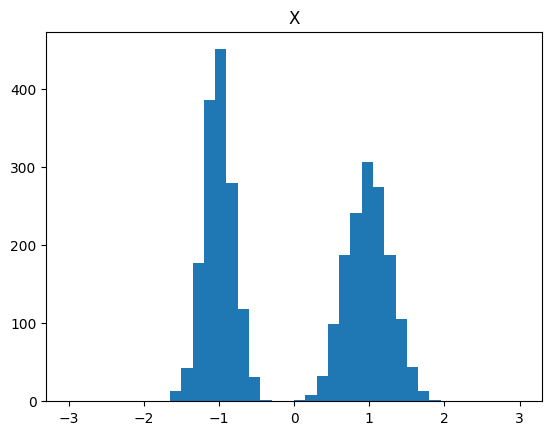

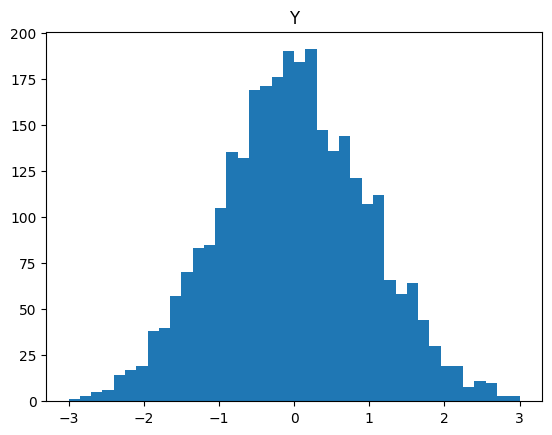

In [ ]:
Np = 3000
x00, y00 = sampling_nd(Np=Np, seed=0, n=1)

bins = 40
lim = 3.
fig, ax = plt.subplots();
ax.set_title("X")
_ = ax.hist(x00, bins=bins, range=[-lim,lim])

fig, ax = plt.subplots();
ax.set_title("Y")
_ = ax.hist(y00, bins=bins, range=[-lim,lim])

### Compute the OT between x and y using EMD

In [ ]:
x_emd = x00.copy()
y_emd = y00.copy()

x_emd, y_emd = find_optimal_map_nd(x_emd, y_emd)

w_emd_xy = np.mean(np.mean(np.sum((x_emd-y_emd)**2, axis=1)))
print("Wasserstein distance computed using EMD: ", w_emd_xy)

Wasserstein distance computed using EMD:  0.18482630716152137


### Compute the map using the new OT method

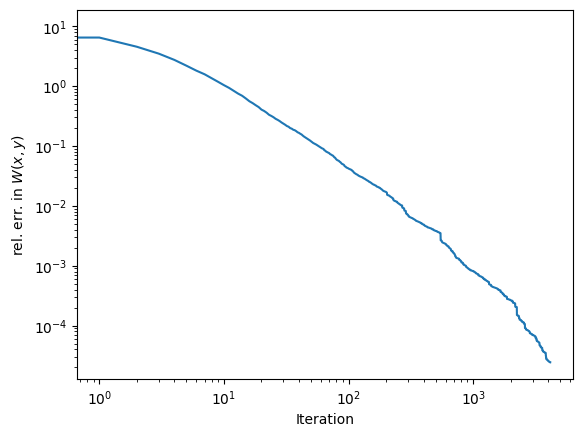

In [ ]:
x = x00.copy()
y = y00.copy()

x_coll, y_coll, dists_coll_xy, nt = find_OT_collision_nd(x, y, tol=1e-9, MinIter=1000, MaxIter=10000)

fig, ax = plt.subplots();
ax.plot( (np.array(dists_coll_xy)-w_emd_xy)/w_emd_xy )
ax.set_ylabel(r"rel. err. in $W(x,y)$")
ax.set_xlabel(r"Iteration")
ax.set_xscale("log")
ax.set_yscale("log")

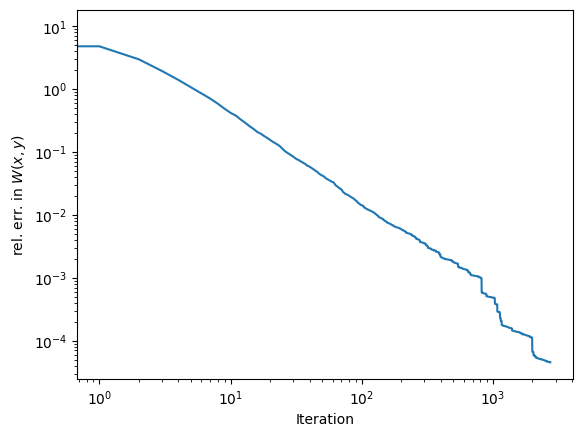

In [ ]:
## W2 cost
def total_cost(x_m, ids_m):
  Nm_m = x_m.shape[0]
  Np_m = x_m.shape[1]
  y = 0
  for i in range(Nm_m):
    for j in range(i+1, Nm_m):
        y += np.sum( np.sum( (x_m[i, :, :]-x_m[j, :, :])**2 , axis=1) )
  return y/Np_m

def change_cost(x_m, ids_m, i1s_m, i2s_m, k_m, before=True):
  Nm_m = x_m.shape[0]
  s_m = np.ones(len(i1s_m))
  for j_m in range(Nm_m):
    if j_m != k_m:
        s_m += np.sum( np.sum( (x_m[j_m,:,:]-x_m[k_m,:,:])**2, axis=1) )

        if before is False:
          s_m -= np.sum( (x_m[j_m,i1s_m,:]-x_m[k_m,i1s_m,:])**2, axis=1)
          s_m -= np.sum( (x_m[j_m,i2s_m,:]-x_m[k_m,i2s_m,:])**2, axis=1)
          s_m += np.sum( (x_m[j_m,i1s_m,:]-x_m[k_m,i2s_m,:])**2, axis=1)
          s_m += np.sum( (x_m[j_m,i2s_m,:]-x_m[k_m,i1s_m,:])**2, axis=1)

  return s_m

x = x00.copy()
y = y00.copy()


X=np.zeros((2,x.shape[0],x.shape[1]))
X[0,:] = x
X[1,:] = y

X, ids, dists_coll_xy, nt = find_OT_collision_nd_nmargins(X, Total_Cost=total_cost,  Change_Cost=change_cost, MinIter=1000, MaxIter=5000, tol = 1e-9, avg_window=20)

fig, ax = plt.subplots();
ax.plot( (np.array(dists_coll_xy)-w_emd_xy)/w_emd_xy )
ax.set_ylabel(r"rel. err. in $W(x,y)$")
ax.set_xlabel(r"Iteration")
ax.set_xscale("log")
ax.set_yscale("log")

Text(0, 0.5, '$X^{b}$')

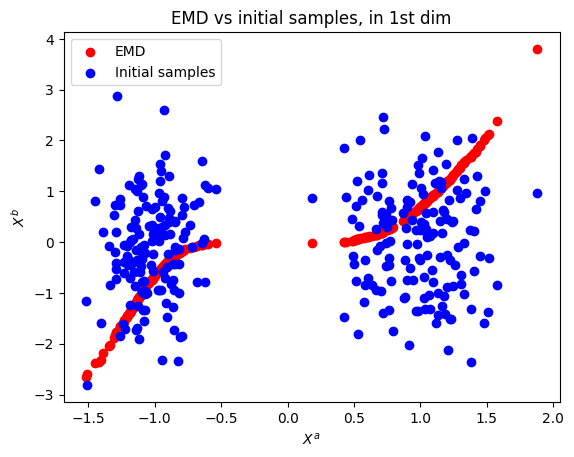

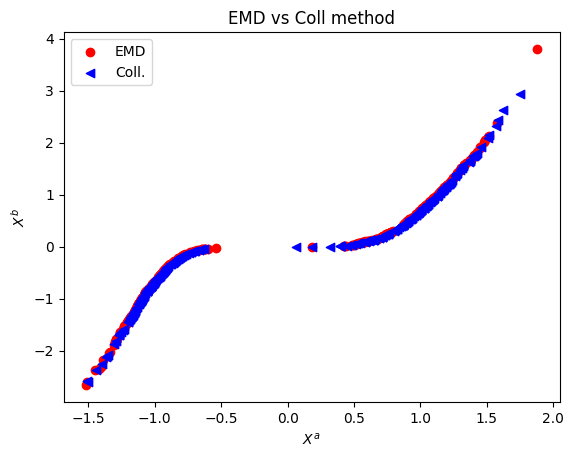

In [ ]:
fig, ax = plt.subplots();
ax.scatter(x_emd[::10], y_emd[::10], color='red', label="EMD")
ax.scatter(x00[::10], y00[::10], color='blue', label="Initial samples")
ax.legend()
ax.set_title("EMD vs initial samples, in 1st dim")
ax.set_xlabel(r"$X^{a}$")
ax.set_ylabel(r"$X^{b}$")

fig, ax = plt.subplots();
ax.scatter(x_emd[::10], y_emd[::10], color='red', label="EMD")
ax.scatter(X[0,::10], X[1,::10], color='blue', label="Coll.", marker="<")
ax.legend()
ax.set_title("EMD vs Coll method")
ax.set_xlabel(r"$X^{a}$")
ax.set_ylabel(r"$X^{b}$")


## Generate test samples, d=2

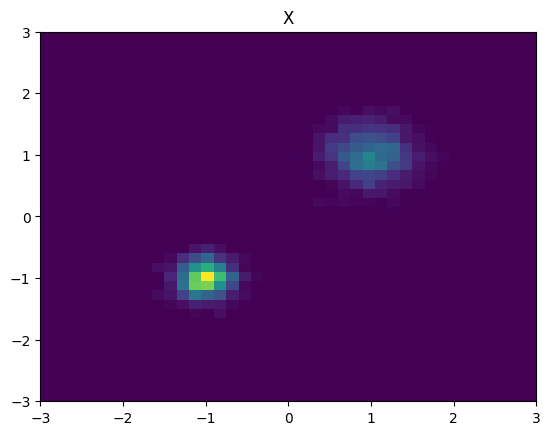

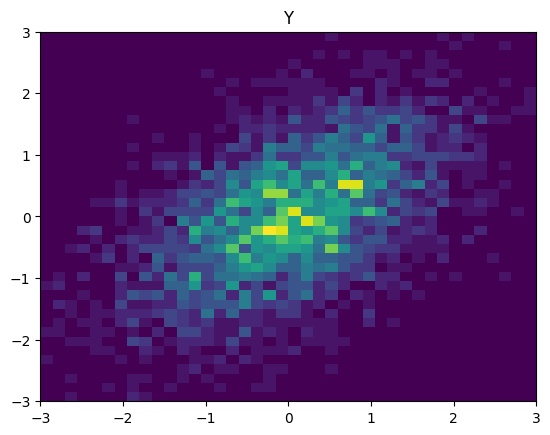

In [ ]:
Np = 3000
x00, y00 = sampling_nd(Np=Np, seed=0, n=2)

bins = 40
lim = 3.
fig, ax = plt.subplots();
ax.set_title("X")
_ = ax.hist2d(x00[:,0], x00[:,1], bins=bins, range=[[-lim,lim],[-lim,lim]])

fig, ax = plt.subplots();
ax.set_title("Y")
_ = ax.hist2d(y00[:,0], y00[:,1], bins=bins, range=[[-lim,lim],[-lim,lim]])

### Compute the OT between x and y using EMD

In [ ]:
x_emd = x00.copy()
y_emd = y00.copy()

x_emd, y_emd = find_optimal_map_nd(x_emd, y_emd)

w_emd_xy = np.mean(np.mean(np.sum((x_emd-y_emd)**2, axis=1)))
print("Wasserstein distance computed using EMD: ", w_emd_xy)

Wasserstein distance computed using EMD:  0.6704630820738033


### Compute the map using the new OT method

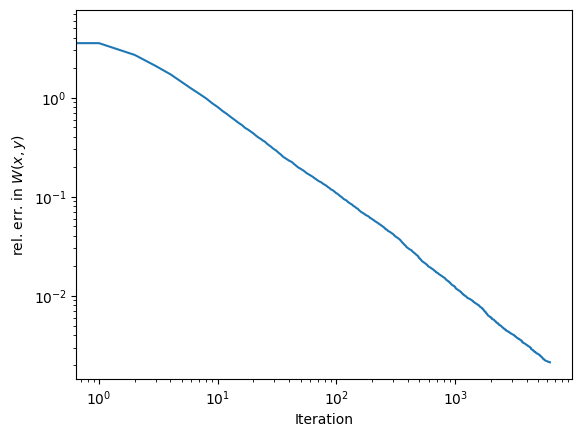

In [ ]:
x = x00.copy()
y = y00.copy()

x_coll, y_coll, dists_coll_xy, nt = find_OT_collision_nd(x, y, tol=1e-9, MinIter=1000, MaxIter=10000)

fig, ax = plt.subplots();
ax.plot( (np.array(dists_coll_xy)-w_emd_xy)/w_emd_xy )
ax.set_ylabel(r"rel. err. in $W(x,y)$")
ax.set_xlabel(r"Iteration")
ax.set_xscale("log")
ax.set_yscale("log")

In [ ]:
## W2 cost
def total_cost(x_m, ids_m):
  Nm_m = x_m.shape[0]
  Np_m = x_m.shape[1]
  y = 0
  for i in range(Nm_m):
    for j in range(i+1, Nm_m):
        y += np.sum( np.sum( (x_m[i, :, :]-x_m[j, :, :])**2 , axis=1) )
  return y/Np_m

def change_cost(x_m, ids_m, i1s_m, i2s_m, k_m, before=True):
  Nm_m = x_m.shape[0]
  s_m = np.ones(len(i1s_m))
  for j_m in range(Nm_m):
    if j_m != k_m:
        s_m += np.sum( np.sum( (x_m[j_m,:,:]-x_m[k_m,:,:])**2, axis=1) )

        if before is False:
          s_m -= np.sum( (x_m[j_m,i1s_m,:]-x_m[k_m,i1s_m,:])**2, axis=1)
          s_m -= np.sum( (x_m[j_m,i2s_m,:]-x_m[k_m,i2s_m,:])**2, axis=1)
          s_m += np.sum( (x_m[j_m,i1s_m,:]-x_m[k_m,i2s_m,:])**2, axis=1)
          s_m += np.sum( (x_m[j_m,i2s_m,:]-x_m[k_m,i1s_m,:])**2, axis=1)

  return s_m

x = x00.copy()
y = y00.copy()


X=np.zeros((2,x.shape[0],x.shape[1]))
X[0,:,:] = x
X[1,:,:] = y

X, ids, dists_coll_xy, nt = find_OT_collision_nd_nmargins(X, Total_Cost=total_cost,  Change_Cost=change_cost, MinIter=1000, MaxIter=10000, tol = 1e-12, avg_window=20)

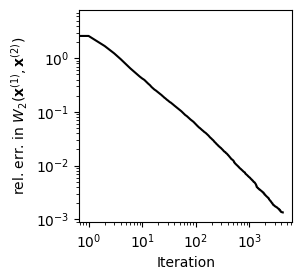

In [ ]:
fig, ax = plt.subplots();
ax.plot( (np.array(dists_coll_xy)-w_emd_xy)/w_emd_xy, color="black")
ax.set_ylabel(r"rel. err. in $W_2(\mathbf{x}^{(1)},\mathbf{x}^{(2)})$")
ax.set_xlabel(r"Iteration")
ax.set_xscale("log")
ax.set_yscale("log")

fig.set_size_inches(size*cm, size*cm)
plt.savefig('drive/MyDrive/OT/2d_bi-modal-multivar_RelErrW2.pdf',format='pdf', bbox_inches="tight", dpi=300);

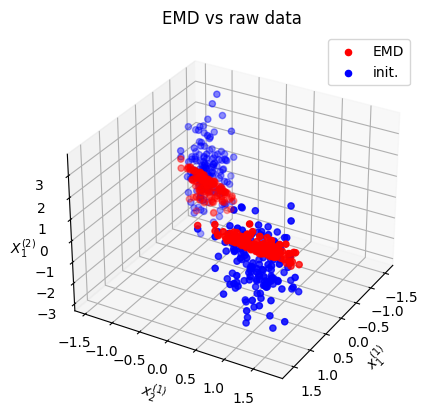

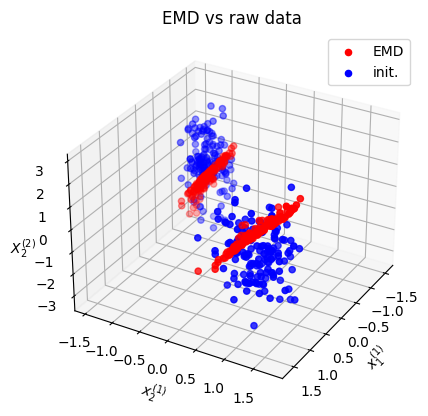

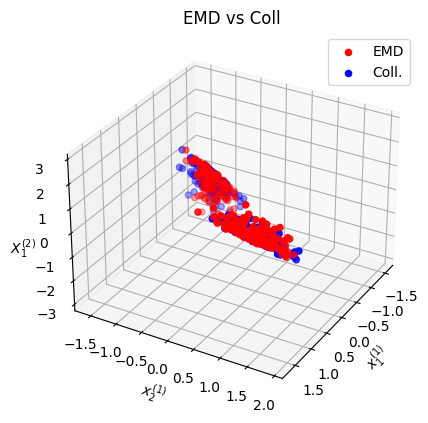

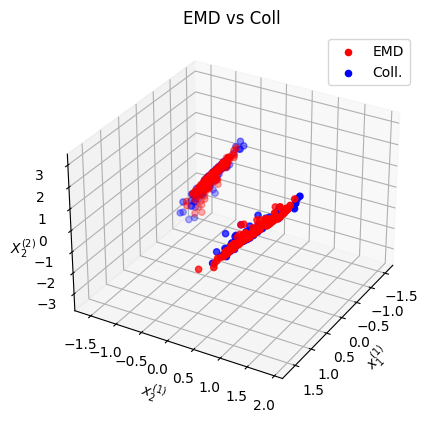

In [ ]:
plt.figure()
ax = plt.axes(projection='3d', elev=30, azim=30)
ax.scatter(x_emd[::10,0], x_emd[::10,1], y_emd[::10,0], color='red', label="EMD")
ax.scatter(x00[::10,0], x00[::10,1], y00[::10,0], color='blue', label="init.")
ax.legend()
ax.set_title("EMD vs raw data")
ax.set_xlabel(r"$x^{(1)}_1$")
ax.set_ylabel(r"$x^{(1)}_2$")
#ax.set_zlabel(r"$X^b_1$")
#ax.zaxis._axinfo['juggled'] = (1, 2, 2)
#ax.zaxis.labelpad = 50
#ax.set_zlabel(r"$X^b_1$", labelpad=20)
#ax.zaxis.set_label_coords(-0.1, 0.5)
ax.text2D(-0.1, 0.4, r"$X^{(2)}_1$", transform=ax.transAxes)
fig.set_size_inches(size*cm, size*cm)
plt.savefig('drive/MyDrive/OT/2d_bi-modal-multivar_scatterEMDinit0.pdf',format='pdf', dpi=300); #bbox_inches="tight"


plt.figure()
ax = plt.axes(projection='3d', elev=30, azim=30)
ax.scatter(x_emd[::10,0], x_emd[::10,1], y_emd[::10,1], color='red', label="EMD")
ax.scatter(x00[::10,0], x00[::10,1], y00[::10,1], color='blue', label="init.")
ax.legend()
ax.set_title("EMD vs raw data")
ax.set_xlabel(r"$x^{(1)}_1$")
ax.set_ylabel(r"$x^{(1)}_2$")
#ax.set_zlabel(r"$X^b_2$")
ax.text2D(-0.1, 0.4, r"$X^{(2)}_2$", transform=ax.transAxes)
fig.set_size_inches(size*cm, size*cm)
plt.savefig('drive/MyDrive/OT/2d_bi-modal-multivar_scatterEMDinit1.pdf',format='pdf', bbox_inches="tight", dpi=300);


plt.figure()
ax = plt.axes(projection='3d', elev=30, azim=30)
ax.scatter(x_emd[::10,0], x_emd[::10,1], y_emd[::10,0], color='red', label="EMD")
ax.scatter(X[0,::10,0], X[0,::10,1], X[1,::10,0], color='blue', label="Coll.")
ax.legend()
ax.set_title("EMD vs Coll")
ax.set_xlabel(r"$x^{(1)}_1$")
ax.set_ylabel(r"$x^{(1)}_2$")
#ax.set_zlabel(r"$X^b_1$")
fig.set_size_inches(size*cm, size*cm)
ax.text2D(-0.1, 0.4, r"$X^{(2)}_1$", transform=ax.transAxes)
plt.savefig('drive/MyDrive/OT/2d_bi-modal-multivar_scatterEMDfinal0.pdf',format='pdf', bbox_inches="tight", dpi=300);


plt.figure()
ax = plt.axes(projection='3d', elev=30, azim=30)
ax.scatter(x_emd[::10,0], x_emd[::10,1], y_emd[::10,1], color='red', label="EMD")
ax.scatter(X[0,::10,0], X[0,::10,1], X[1,::10,1], color='blue', label="Coll.")
ax.legend()
ax.set_title("EMD vs Coll")
ax.set_xlabel(r"$x^{(1)}_1$")
ax.set_ylabel(r"$x^{(1)}_2$")
#ax.set_zlabel(r"$X^b_2$")
ax.text2D(-0.1, 0.4, r"$X^{(2)}_2$", transform=ax.transAxes)
fig.set_size_inches(size*cm, size*cm)
plt.savefig('drive/MyDrive/OT/2d_bi-modal-multivar_scatterEMDfinal1.pdf',format='pdf', bbox_inches="tight", dpi=300);


# Example: OT between Swiss roll and ring

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_swiss_roll
import torch
from torch import nn
from sklearn.neighbors import BallTree
import matplotlib.gridspec as gridspec
from mpl_toolkits.mplot3d import Axes3D
device="cpu"

# Sample Y from swiss roll and plot it
def sample_batch(size, noise=0.5):
    x, _= make_swiss_roll(size, noise=noise)
    return x[:, [0, 2]] / 10.0 / 1.5

def generate_ring_samples(num_samples, center=(0, 0), radius=2, thickness=1, noise=0.1):
    # Generate points on the circumference of the ring
    angles = np.random.rand(int(num_samples/2)) * 2 * np.pi
    inner_radius = radius - thickness / 2
    outer_radius = inner_radius #radius + thickness / 2
    x = center[0] + np.cos(angles) * (inner_radius + np.random.randn(int(num_samples/2)) * noise)
    y = center[1] + np.sin(angles) * (inner_radius + np.random.randn(int(num_samples/2)) * noise)

    # Combine inner and outer circle samples
    ring_samples = np.column_stack((np.concatenate((x, center[0] + np.cos(angles) * (outer_radius + np.random.randn(int(num_samples/2)) * noise))),
                                    np.concatenate((y, center[1] + np.sin(angles) * (outer_radius + np.random.randn(int(num_samples/2)) * noise)))))
    return ring_samples/1.5


Np = 10000 # number of points/particles/samples

Y = sample_batch(Np)
Y00 = Y.copy()

X = generate_ring_samples(Np)
X00 = X.copy()

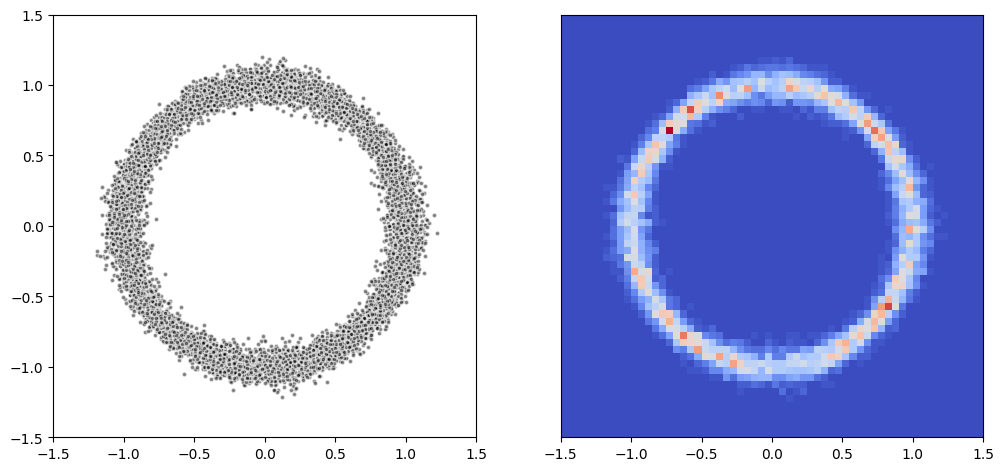

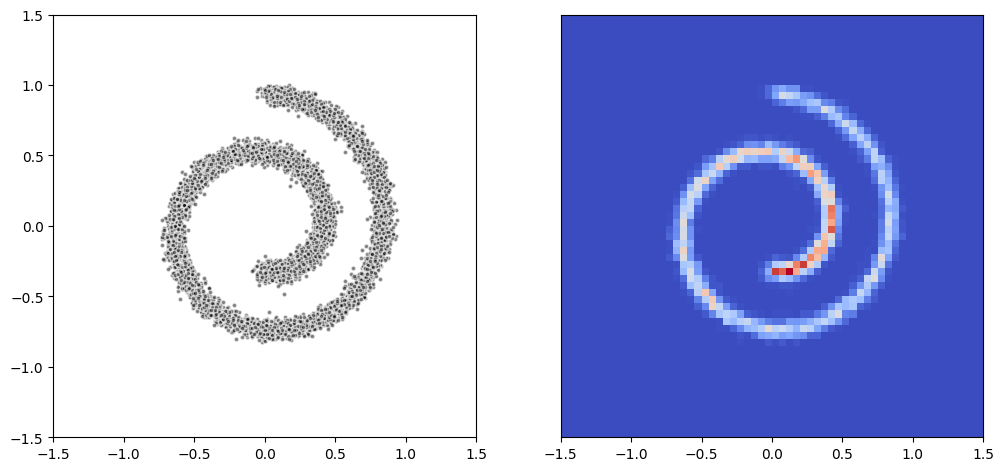

In [ ]:
def plot_2d_density(x, xp=None, bins=60, range=[[-1.5,1.5],[-1.5,1.5]]):
    if xp is None:
        xp = x
    fig = plt.figure(figsize=(12, 6))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1.])  # Adjust width_ratios to increase size of second plot

    # Create the first subplot of Y
    ax1 = plt.subplot(gs[0])
    ax1.scatter(*(xp.T), alpha=0.5, color='black', edgecolor='white', s=10)
    ax1.set_aspect('equal', adjustable='box')  # Ensure aspect ratio is 1
    ax1.set_xlim(range[0])
    ax1.set_ylim(range[1])

    # Create the second subplot of Y
    ax2 = plt.subplot(gs[1])
    hist = ax2.hist2d(x[:,0 ], x[:, 1], bins=bins, density=True, cmap='coolwarm', range=range)
    ax2.set_aspect('equal', adjustable='box')  # Ensure aspect ratio is 1
    ax2.set_yticks([])  # Removes x-ticks
    ax2.set_yticklabels([])  # Removes x-tick labels
    return fig

fig1 = plot_2d_density(X)
fig2 = plot_2d_density(Y)


plt.show()

In [ ]:
import time
X0 = X00.copy()
Y0 = Y00.copy()

start = time.time()
X_emd, Y_emd = find_optimal_map_nd(X0, Y0)
end = time.time()

print(end-start)

59.94130992889404


In [ ]:
import torch
from torch import nn

class Model(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=100):
        super(Model, self).__init__()
        self.fc = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, input_dim)
        )

    def forward(self, x):
        return self.fc(x)

    def loss(self, X: torch.Tensor, Y: torch.Tensor) -> torch.Tensor:
        loss = torch.mean(torch.sum((self.forward(X) - Y) ** 2, dim=1))
        return loss


Epoch 1000, Loss: 0.003046112833544612
Epoch 2000, Loss: 0.0015546598006039858
Epoch 3000, Loss: 0.001043755910359323
Epoch 4000, Loss: 0.00098642788361758
Epoch 5000, Loss: 0.0007067605620250106


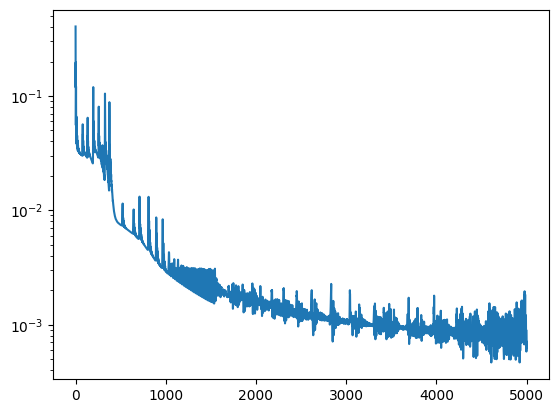

In [ ]:
from torch import nn, optim

X = torch.tensor(X_emd, dtype=torch.float32)
Y = torch.tensor(Y_emd, dtype=torch.float32)


# Create a simple model and optimizer
model = Model(input_dim=2)
optimizer = optim.Adam(model.parameters(), lr=5e-3)

# Training loop
n_epochs = 5000
losses = []

for epoch in range(1, n_epochs+1):
      optimizer.zero_grad()
      loss = model.loss(X, Y)
      loss.backward()
      optimizer.step()
      if epoch % 1000 == 0:
          print(f"Epoch {epoch}, Loss: {loss.item()}")
      losses.append(loss.item())

model.eval()

plt.plot(losses)
plt.yscale("log")

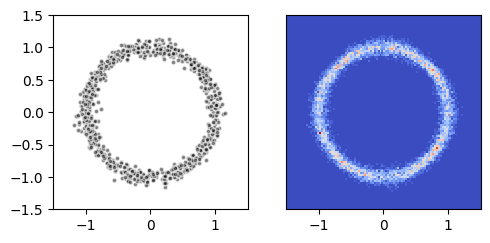

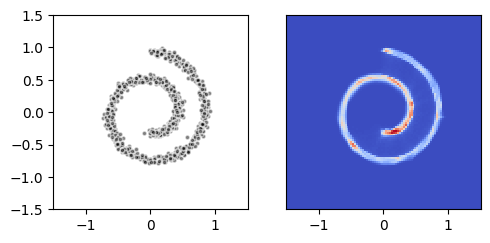

In [ ]:
Xtest = generate_ring_samples(1e6)
Xtest = torch.tensor(Xtest, dtype=torch.float32)
Ytest = model.forward(Xtest)

fig1 = plot_2d_density(X00, xp=X00[::10,:], bins=100)
fig1.set_size_inches(size*cm*2, size*cm*2)
plt.savefig('drive/MyDrive/OT/2d_swiss-roll-ring_EMDfit_input.pdf',format='pdf', bbox_inches="tight", dpi=300);


fig2 = plot_2d_density(Ytest.detach().numpy(), xp=Y00[::10,:], bins=100)
fig2.set_size_inches(size*cm*2, size*cm*2)
plt.savefig('drive/MyDrive/OT/2d_swiss-roll-ring_EMDfit_output.pdf',format='pdf', bbox_inches="tight", dpi=300);

plt.show()

In [ ]:
X=np.zeros((2,X00.shape[0],X00.shape[1]))
X[0,:,:] = X00.copy()
X[1,:,:] = Y00.copy()

Xcoll, ids, dists_coll_xy, nt = find_OT_collision_nd_nmargins(X, Total_Cost=total_cost,  Change_Cost=change_cost, MinIter=1000, MaxIter=10000, tol = 1e-9, avg_window=20)

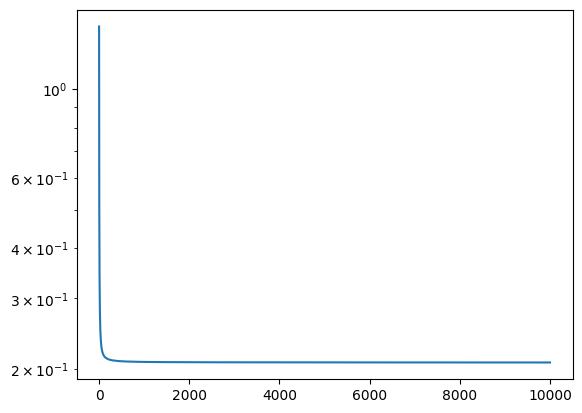

In [ ]:
plt.plot(dists_coll_xy)
plt.yscale('log')

Epoch 1000, Loss: 0.0028521523345261812
Epoch 2000, Loss: 0.0015680007636547089
Epoch 3000, Loss: 0.001246024388819933
Epoch 4000, Loss: 0.0010290697682648897
Epoch 5000, Loss: 0.0010009268298745155


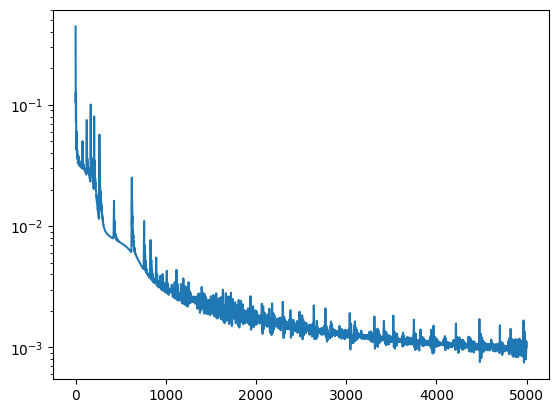

In [ ]:
from torch import nn, optim

X = torch.tensor(Xcoll[0,:,:], dtype=torch.float32)
Y = torch.tensor(Xcoll[1,:,:], dtype=torch.float32)


# Create a simple model and optimizer
model_coll = Model(input_dim=2)
optimizer = optim.Adam(model_coll.parameters(), lr=5e-3)

# Training loop
n_epochs = 5000
losses = []

for epoch in range(1, n_epochs+1):
      optimizer.zero_grad()
      loss = model_coll.loss(X, Y)
      loss.backward()
      optimizer.step()
      if epoch % 1000 == 0:
          print(f"Epoch {epoch}, Loss: {loss.item()}")
      losses.append(loss.item())

model_coll.eval()

plt.plot(losses)
plt.yscale("log")

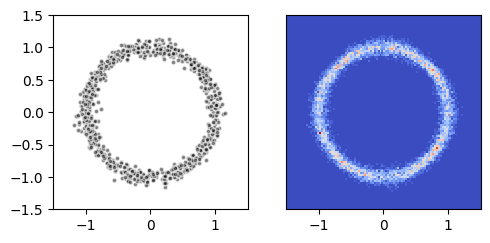

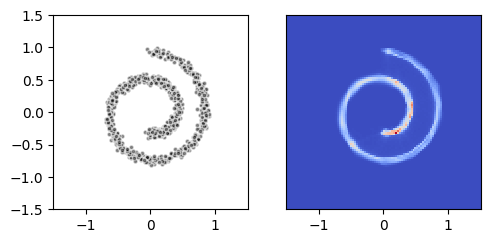

In [ ]:
Ytest_coll = model_coll.forward(Xtest)

fig1 = plot_2d_density(X00, xp=X00[::10,:], bins=100)
fig1.set_size_inches(size*cm*2, size*cm*2)
plt.savefig('drive/MyDrive/OT/2d_swiss-roll-ring_collfit_input.pdf',format='pdf', bbox_inches="tight", dpi=300);


fig2 = plot_2d_density(Ytest_coll.detach().numpy(), xp=Xcoll[1,::10,:], bins=100)
fig2.set_size_inches(size*cm*2, size*cm*2)
plt.savefig('drive/MyDrive/OT/2d_swiss-roll-ring_collfit_output.pdf',format='pdf', bbox_inches="tight", dpi=300);

plt.show()

# Convergence study w.r.t Np

In [38]:
def total_cost(x_m, ids_m):
  Nm_m = x_m.shape[0]
  Np_m = x_m.shape[1]
  y = 0
  for i in range(Nm_m):
    for j in range(i+1, Nm_m):
        #y += np.sum( np.sum( (x_m[i, ids_m[i,:]]-x_m[j, ids_m[j,:],:])**2 , axis=1) )
        y += np.sum( np.sum( (x_m[i, :, :]-x_m[j, :, :])**2 , axis=1) )
  return y/Np_m

def change_cost(x_m, ids_m, i1s_m, i2s_m, k_m, before=True):
  Nm_m = x_m.shape[0]
  s_m = np.ones(len(i1s_m))
  for j_m in range(Nm_m):
    if j_m != k_m:
        #s_m += np.sum( np.sum( (x_m[j_m,ids_m[j_m,:],:]-x_m[k_m,ids_m[k_m,:],:])**2, axis=1) )
        s_m += np.sum( np.sum( (x_m[j_m,:,:]-x_m[k_m,:,:])**2, axis=1) )

        if before is False:
          #s_m -= np.sum( (x_m[j_m,ids_m[j_m,i1s_m],:]-x_m[k_m,ids_m[k_m,i1s_m],:])**2, axis=1)
          #s_m -= np.sum( (x_m[j_m,ids_m[j_m,i2s_m],:]-x_m[k_m,ids_m[k_m,i2s_m],:])**2, axis=1)
          #s_m += np.sum( (x_m[j_m,ids_m[j_m,i1s_m],:]-x_m[k_m,ids_m[k_m,i2s_m],:])**2, axis=1)
          #s_m += np.sum( (x_m[j_m,ids_m[j_m,i2s_m],:]-x_m[k_m,ids_m[k_m,i1s_m],:])**2, axis=1)

          s_m -= np.sum( (x_m[j_m,i1s_m,:]-x_m[k_m,i1s_m,:])**2, axis=1)
          s_m -= np.sum( (x_m[j_m,i2s_m,:]-x_m[k_m,i2s_m,:])**2, axis=1)
          s_m += np.sum( (x_m[j_m,i1s_m,:]-x_m[k_m,i2s_m,:])**2, axis=1)
          s_m += np.sum( (x_m[j_m,i2s_m,:]-x_m[k_m,i1s_m,:])**2, axis=1)

  return s_m

0.3276439751706077
time:  0.02455306053161621
0.004885418662278625


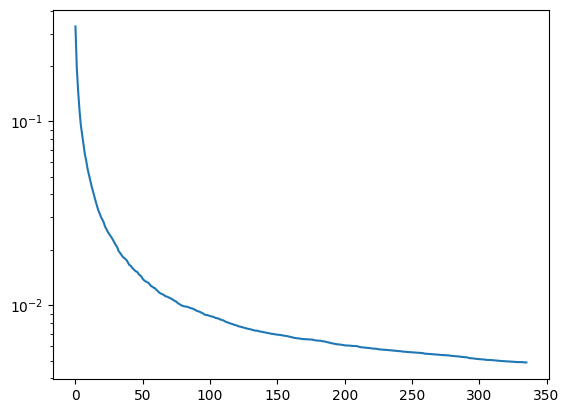

In [5]:
from lib.collision_wrapper import find_OT_collision as newot
import time

Np = 1000
dim = 2
x00 = np.random.uniform(0,1,(Np,dim))
y00 = np.random.uniform(0,1,(Np,dim))

X=np.zeros((2,x00.shape[0],x00.shape[1]))
X[0,:,:] = x00
X[1,:,:] = y00

print( np.mean( np.sum( (X[0,:,:] - X[1,:,:])**2 , axis=1 ) ) )

start_time = time.time()
x, hist = newot(X)
end_time = time.time()
print("time: ",end_time-start_time)

print( np.mean( np.sum( (X[0,:,:] - X[1,:,:])**2 , axis=1 ) ) )
plt.plot(hist)
plt.yscale("log")

# uniform to uniform

In [26]:
import time
from lib.collision_wrapper import find_OT_collision as newot
import tracemalloc
tracemalloc.start()

dim = 2
Nps = [500, 1000, 2000, 4000, 8000, 16000] #, 8000, 16000] #, 25600, 51200, 102400]

errors_xy = []

mem_emd  = []
mem_coll = []
ex_time_emd  = []
ex_time_coll = []
iter_coll_xy = []
hist_coll_w = [[] for i in range(len(Nps))]
err_hist_coll_w = [[] for i in range(len(Nps))]

k=0
navg = 5
nd = 2
for Np in Nps:
  print("Np: ", Np)
  k = k + 1

  emd_t = 0
  coll_t = 0
  errors_xy_ = 0
  errors_yz_ = 0
  errors_xz_ = 0
  nt_xy_ = 0
  nt_yz_ = 0
  emd_avgmem = 0.0
  coll_avgmem = 0.0
  for av in range(navg):
      #x00, y00 = sampling_nd(Np=Np, seed=av, n=nd)
      x00 = np.random.uniform(0,1,(Np,dim))
      y00 = np.random.uniform(0,1,(Np,dim))
    
      ## compute EMD
      x_emd = x00.copy(); y_emd = y00.copy();
      start_time = time.time()
      tracemalloc.reset_peak()
      x_emd, y_emd = find_optimal_map_nd(x_emd, y_emd)
      first_size, first_peak = tracemalloc.get_traced_memory()
      emd_avgmem += first_peak
      emd_t += time.time() - start_time
      print("EMD Done")

      ## compute collision based
      x_coll = x00.copy(); y_coll = y00.copy();

      X=np.zeros((2,x00.shape[0],x00.shape[1]))
      X[0,:,:] = x00
      X[1,:,:] = y00

      start_time = time.time()
      tracemalloc.reset_peak()
      X, dists_coll_xy = newot(X, MinIter=3000, MaxIter=3000, tol = 1e-3, avg_window=20)
      first_size, first_peak = tracemalloc.get_traced_memory()
      coll_avgmem += first_peak
      coll_t += time.time() - start_time
      print("coll Done")

      x_coll = X[0,:,:]
      y_coll = X[1,:,:]

      w_emd_xy = np.mean(np.sum((x_emd-y_emd)**2, axis=1))
      hist_coll_w[k-1].append(np.array( (dists_coll_xy)) )
      err_hist_coll_w[k-1].append( abs( np.array( (dists_coll_xy)) - w_emd_xy) )
      #nt_xy_ += nt_xy

  #iter_coll_xy.append(nt_xy_/navg)

  mem_emd.append(emd_avgmem/navg)
  mem_coll.append(coll_avgmem/navg)    
  ex_time_emd.append(emd_t/navg)
  ex_time_coll.append(coll_t/navg)
  errors_xy.append( errors_xy_/navg )

Np:  500
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
Np:  1000
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
Np:  2000
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
Np:  4000
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
Np:  8000
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
Np:  16000
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done


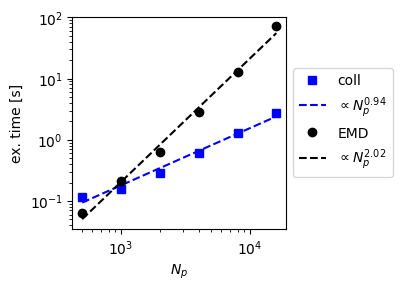

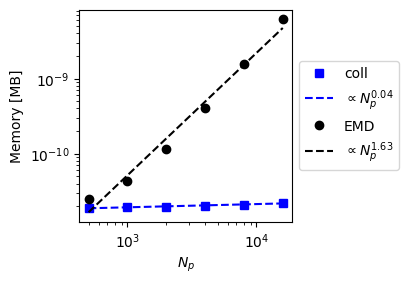

In [31]:
from scipy.stats import linregress

def fit_xp(x, y):
    log_x = np.log10(x)
    log_y = np.log10(y)

    slope, intercept, r_value, p_value, std_err = linregress(log_x, log_y)
    slope_str = f'{slope:.2f}'

    fitted_y = 10**(intercept + slope * log_x)
    return slope, slope_str, fitted_y

###############################################
fig, ax = plt.subplots();

ax.plot(Nps, ex_time_coll, color="blue", marker="s", label="coll", linewidth=0)
slope_coll, slope_coll_str, ex_time_coll_fit_y = fit_xp(Nps, ex_time_coll)
ax.plot(Nps, ex_time_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

ax.plot(Nps, ex_time_emd, color="black", marker="o", label="EMD", linewidth=0)
slope_emd, slope_emd_str, ex_time_emd_fit_y = fit_xp(Nps, ex_time_emd)
ax.plot(Nps, ex_time_emd_fit_y, label=r'$\propto N_p^{'+slope_emd_str+'}$', color='black', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"ex. time [s]")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.set_size_inches(size*cm, size*cm)
plt.savefig(str(dim)+'d_uniform_ex_time_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

###############################################
fig, ax = plt.subplots();

mem_coll = np.array(mem_coll)/1e6
ax.plot(Nps, np.array(mem_coll), color="blue", marker="s", label="coll", linewidth=0)
slope_coll, slope_coll_str, mem_coll_fit_y = fit_xp(Nps, mem_coll)
ax.plot(Nps, mem_coll_fit_y, label=r'$\propto N_p^{'+slope_coll_str+'}$', color='blue', linestyle="--")

mem_emd = np.array(mem_emd)/1e6
ax.plot(Nps, mem_emd, color="black", marker="o", label="EMD", linewidth=0)
slope_emd, slope_emd_str, mem_emd_fit_y = fit_xp(Nps, mem_emd)
ax.plot(Nps, mem_emd_fit_y, label=r'$\propto N_p^{'+slope_emd_str+'}$', color='black', linestyle="--")

plt.legend()
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_xlabel(r"$N_p$")
ax.set_ylabel(r"Memory [MB]")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.set_size_inches(size*cm, size*cm)
plt.savefig(str(dim)+'d_uniform_mem_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);


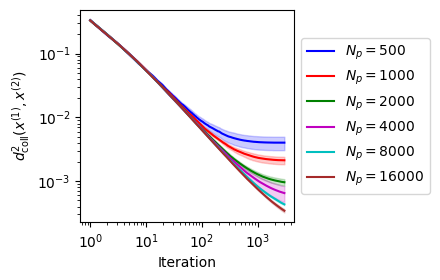

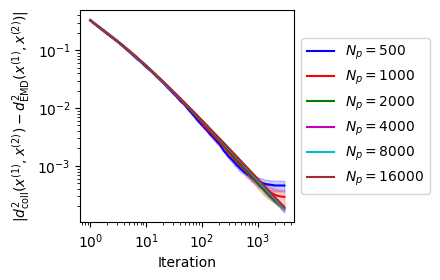

In [30]:
fig, ax = plt.subplots();
cls = ["blue", "red", "green", "m", "c", "brown", "gray", "salmon", "blueviolet", "lime", "chocolate"]
for k in range(len(Nps)):
    nmin = 10000000
    for jj in range(len(hist_coll_w[k])):
      if len(hist_coll_w[k][jj]) < nmin:
        nmin = len(hist_coll_w[k][jj])-1
    hist_coll_w_k = np.zeros( (len(hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        hist_coll_w_k[jj,ii] = hist_coll_w[k][jj][ii]
    xx = [i+1 for i in range(nmin)]
    mean_err = np.mean(hist_coll_w_k, axis=0)
    std_err = np.var(hist_coll_w_k,axis=0)**0.5
    ax.plot(xx, mean_err, color=cls[k], markevery=100, label=r"$N_p="+str(Nps[k])+"$")
    plt.fill_between(xx, mean_err-std_err, mean_err+std_err, color=cls[k], alpha=0.2)
    #for av in range(navg):
    #    ax.plot(hist_coll_w[k][av], color=cls[k], marker=markers[av], markevery=100, label=r"$N_p="+str(Nps[k])+"\ rep.\ "+str(av+1)+"$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$d^2_\mathrm{coll}({x}^{(1)},{x}^{(2)})$")

ax.set_xlabel("Iteration")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.set_size_inches(size*cm, size*cm)
plt.savefig(str(dim)+'d_uniform_evol_rel_error_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

fig, ax = plt.subplots();
for k in range(len(Nps)):
    nmin = 10000000
    for jj in range(len(err_hist_coll_w[k])):
      if len(err_hist_coll_w[k][jj]) < nmin:
        nmin = len(err_hist_coll_w[k][jj])-1
    err_hist_coll_w_k = np.zeros( (len(err_hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        err_hist_coll_w_k[jj,ii] = err_hist_coll_w[k][jj][ii]
    xx = [i+1 for i in range(nmin)]
    mean_err = np.mean(err_hist_coll_w_k, axis=0)
    std_err = np.var(err_hist_coll_w_k,axis=0)**0.5
    ax.plot(xx, mean_err, color=cls[k], markevery=100, label=r"$N_p="+str(Nps[k])+"$")
    plt.fill_between(xx, mean_err-std_err, mean_err+std_err, color=cls[k], alpha=0.2)
    #for av in range(navg):
    #    ax.plot(hist_coll_w[k][av], color=cls[k], marker=markers[av], markevery=100, label=r"$N_p="+str(Nps[k])+"\ rep.\ "+str(av+1)+"$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"$| d^2_\mathrm{coll}({x}^{(1)},{x}^{(2)}) - d^2_\mathrm{EMD}({x}^{(1)},{x}^{(2)})|$")
ax.set_xlabel("Iteration")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.set_size_inches(size*cm, size*cm)
plt.savefig(str(dim)+'d_uniform_evol_rel_error_EMD_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

# Normal to Normal

In [ ]:
import time
from lib.collision_wrapper import find_OT_collision as newot
import tracemalloc
tracemalloc.start()

dim = 2
Nps = [500, 1000, 2000, 4000, 8000, 16000] #, 8000, 16000] #, 25600, 51200, 102400]

errors_xy = []

mem_emd  = []
mem_coll = []
ex_time_emd  = []
ex_time_coll = []
iter_coll_xy = []
hist_coll_w = [[] for i in range(len(Nps))]
err_hist_coll_w = [[] for i in range(len(Nps))]

k=0
navg = 5
nd = 2
for Np in Nps:
  print("Np: ", Np)
  k = k + 1

  emd_t = 0
  coll_t = 0
  errors_xy_ = 0
  errors_yz_ = 0
  errors_xz_ = 0
  nt_xy_ = 0
  nt_yz_ = 0
  emd_avgmem = 0.0
  coll_avgmem = 0.0
  for av in range(navg):
      #x00, y00 = sampling_nd(Np=Np, seed=av, n=nd)
      x00 = np.random.normal(0,1,(Np,dim))
      y00 = np.random.normal(0,1,(Np,dim))
    
      ## compute EMD
      x_emd = x00.copy(); y_emd = y00.copy();
      start_time = time.time()
      tracemalloc.reset_peak()
      x_emd, y_emd = find_optimal_map_nd(x_emd, y_emd)
      first_size, first_peak = tracemalloc.get_traced_memory()
      emd_avgmem += first_peak
      emd_t += time.time() - start_time
      print("EMD Done")

      ## compute collision based
      x_coll = x00.copy(); y_coll = y00.copy();

      X=np.zeros((2,x00.shape[0],x00.shape[1]))
      X[0,:,:] = x00
      X[1,:,:] = y00

      start_time = time.time()
      tracemalloc.reset_peak()
      X, dists_coll_xy = newot(X, MinIter=3000, MaxIter=3000, tol = 1e-3, avg_window=20)
      first_size, first_peak = tracemalloc.get_traced_memory()
      coll_avgmem += first_peak
      coll_t += time.time() - start_time
      print("coll Done")

      x_coll = X[0,:,:]
      y_coll = X[1,:,:]

      w_emd_xy = np.mean(np.sum((x_emd-y_emd)**2, axis=1))
      hist_coll_w[k-1].append(np.array( (dists_coll_xy)) )
      err_hist_coll_w[k-1].append( abs( np.array( (dists_coll_xy)) - w_emd_xy) )
      #nt_xy_ += nt_xy

  #iter_coll_xy.append(nt_xy_/navg)

  mem_emd.append(emd_avgmem/navg)
  mem_coll.append(coll_avgmem/navg)    
  ex_time_emd.append(emd_t/navg)
  ex_time_coll.append(coll_t/navg)
  errors_xy.append( errors_xy_/navg )

Np:  500
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
Np:  1000
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
Np:  2000
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
Np:  4000
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
Np:  8000
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
Np:  16000


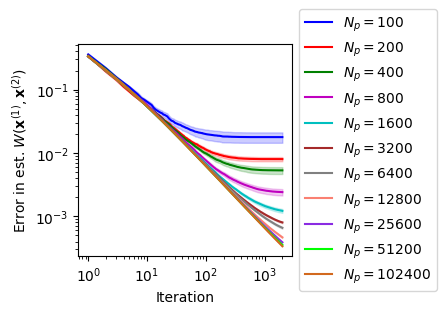

In [25]:
fig, ax = plt.subplots();
cls = ["blue", "red", "green", "m", "c", "brown", "gray", "salmon", "blueviolet", "lime", "chocolate"]
for k in range(len(Nps)):
    nmin = 10000000
    for jj in range(len(hist_coll_w[k])):
      if len(hist_coll_w[k][jj]) < nmin:
        nmin = len(hist_coll_w[k][jj])
    hist_coll_w_k = np.zeros( (len(hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        hist_coll_w_k[jj,ii] = hist_coll_w[k][jj][ii]
    xx = [i+1 for i in range(nmin)]
    mean_err = np.mean(hist_coll_w_k, axis=0)
    std_err = np.var(hist_coll_w_k,axis=0)**0.5
    ax.plot(xx, mean_err, color=cls[k], markevery=100, label=r"$N_p="+str(Nps[k])+"$")
    plt.fill_between(xx, mean_err-std_err/2, mean_err+std_err/2, color=cls[k], alpha=0.2)
    #for av in range(navg):
    #    ax.plot(hist_coll_w[k][av], color=cls[k], marker=markers[av], markevery=100, label=r"$N_p="+str(Nps[k])+"\ rep.\ "+str(av+1)+"$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"Error in est. $W(\mathbf{x}^{(1)},\mathbf{x}^{(2)})$")
ax.set_xlabel("Iteration")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.set_size_inches(size*cm, size*cm)
plt.savefig(str(dim)+'d_normal_evol_rel_error_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);
#plt.savefig('drive/MyDrive/OT/2d_bi-modal-multivar_evol_rel_error_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

## bi-modal and multi-variate normal distr.

In [11]:
import time
Nps = [100, 200, 400] #, 800, 1600, 3200, 6400]

errors_xy = []

ex_time_emd  = []
ex_time_coll = []
iter_coll_xy = []
hist_coll_w = [[] for i in range(len(Nps))]

k=0
navg = 10
nd = 2
for Np in Nps:
  print("Np: ", Np)
  k = k + 1

  emd_t = 0
  coll_t = 0
  errors_xy_ = 0
  errors_yz_ = 0
  errors_xz_ = 0
  nt_xy_ = 0
  nt_yz_ = 0
  for av in range(navg):
      x00, y00 = sampling_nd(Np=Np, seed=av, n=nd)

      ## compute EMD
      x_emd = x00.copy(); y_emd = y00.copy();

      start_time = time.time()
      x_emd, y_emd = find_optimal_map_nd(x_emd, y_emd)
      emd_t += time.time() - start_time
      print("EMD Done")

      ## compute collision based
      #x_coll = x00.copy(); y_coll = y00.copy();

      X=np.zeros((2,x00.shape[0],x00.shape[1]))
      X[0,:,:] = x00
      X[1,:,:] = y00

      start_time = time.time()
      #x_coll, y_coll, dists_coll_xy, nt_xy = find_OT_collision_nd(x_coll, y_coll, tol=1e-6, MinIter=500, MaxIter=10000)
      X, ids, dists_coll_xy, nt_xy = find_OT_collision_nd_nmargins(X, Total_Cost=total_cost,  Change_Cost=change_cost, MinIter=500, MaxIter=10000, tol = 1e-6, avg_window=20)
      coll_t += time.time() - start_time
      print("coll Done")

      x_coll = X[0,:,:]
      y_coll = X[1,:,:]

      w_emd_xy = np.mean(np.mean(np.sum((x_emd-y_emd)**2, axis=1)))
      w_coll_xy = np.mean(np.mean(np.sum((x_coll-y_coll)**2, axis=1)))
      errors_xy_ += abs(w_emd_xy-w_coll_xy) / w_emd_xy
      hist_coll_w[k-1].append(np.array( (dists_coll_xy)-w_emd_xy)/ w_emd_xy )

      nt_xy_ += nt_xy

  iter_coll_xy.append(nt_xy_/navg)

  ex_time_emd.append(emd_t/navg)
  ex_time_coll.append(coll_t/navg)

  errors_xy.append( errors_xy_/navg )

Np:  100
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
Np:  200
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
Np:  400
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done
EMD Done
coll Done


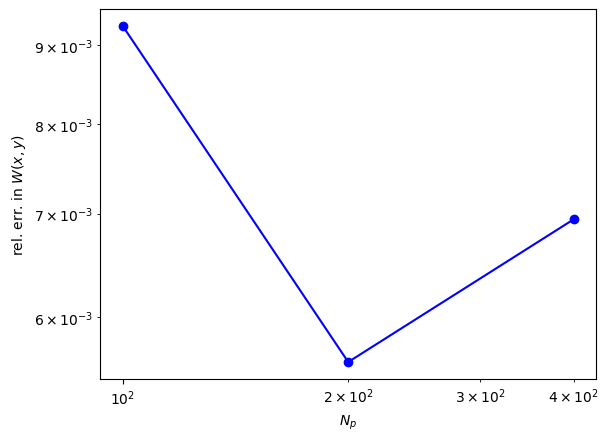

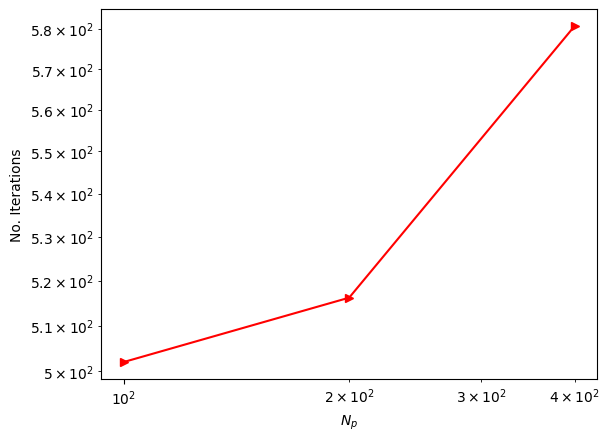

In [12]:
fig, ax = plt.subplots();
ax.plot(Nps, errors_xy, marker="o", color="blue")
ax.set_ylabel(r"rel. err. in $W(x,y)$")
ax.set_xlabel(r"$N_p$")
ax.set_xscale("log")
ax.set_yscale("log")

fig, ax = plt.subplots();
ax.plot(Nps, iter_coll_xy, marker=">", color="red")
ax.set_ylabel(r"No. Iterations")
ax.set_xlabel(r"$N_p$")
ax.set_xscale("log")
ax.set_yscale("log")



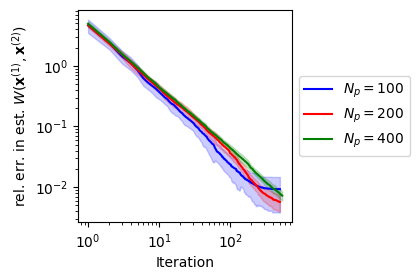

In [13]:
fig, ax = plt.subplots();
cls = ["blue", "red", "green", "m", "c", "brown", "gray"]
for k in range(len(Nps)):
    nmin = 10000000
    for jj in range(len(hist_coll_w[k])):
      if len(hist_coll_w[k][jj]) < nmin:
        nmin = len(hist_coll_w[k][jj])
    hist_coll_w_k = np.zeros( (len(hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        hist_coll_w_k[jj,ii] = hist_coll_w[k][jj][ii]
    xx = [i+1 for i in range(nmin)]
    mean_err = np.mean(hist_coll_w_k, axis=0)
    std_err = np.var(hist_coll_w_k,axis=0)**0.5
    ax.plot(xx, mean_err, color=cls[k], markevery=100, label=r"$N_p="+str(Nps[k])+"$")
    plt.fill_between(xx, mean_err-std_err, mean_err+std_err, color=cls[k], alpha=0.2)
    #for av in range(navg):
    #    ax.plot(hist_coll_w[k][av], color=cls[k], marker=markers[av], markevery=100, label=r"$N_p="+str(Nps[k])+"\ rep.\ "+str(av+1)+"$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"rel. err. in est. $W(\mathbf{x}^{(1)},\mathbf{x}^{(2)})$")
ax.set_xlabel("Iteration")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.set_size_inches(size*cm, size*cm)
#plt.savefig('drive/MyDrive/OT/2d_bi-modal-multivar_evol_rel_error_Np.pdf',format='pdf', bbox_inches="tight", dpi=300);

## Convergence w.r.t dimension

In [4]:
import time
nds = [2**i for i in range(0,10)]

errors_xy = []

ex_time_emd  = []
ex_time_coll = []
iter_coll_xy = []
hist_coll_w = [[] for i in range(len(nds))]

k=0
navg = 10
Np = 1000
for nd in nds:
  print("d: ", nd)
  k = k + 1

  emd_t = 0
  coll_t = 0
  errors_xy_ = 0
  errors_yz_ = 0
  errors_xz_ = 0
  nt_xy_ = 0
  nt_yz_ = 0
  for av in range(navg):
      x00, y00 = sampling_nd(Np=Np, seed=av, n=nd)

      ## compute EMD
      x_emd = x00.copy(); y_emd = y00.copy();

      start_time = time.time()
      x_emd, y_emd = find_optimal_map_nd(x_emd, y_emd)
      emd_t += time.time() - start_time
      print("EMD Done")

      ## compute collision based
      #x_coll = x00.copy(); y_coll = y00.copy();
      X=np.zeros((2,x00.shape[0],x00.shape[1]))
      X[0,:,:] = x00
      X[1,:,:] = y00

      start_time = time.time()
      #x_coll, y_coll, dists_coll_xy, nt_xy = find_OT_collision_nd(x_coll, y_coll, tol=1e-6, MinIter=500, MaxIter=10000)
      X, ids, dists_coll_xy, nt_xy = find_OT_collision_nd_nmargins(X, Total_Cost=total_cost,  Change_Cost=change_cost, MinIter=500, MaxIter=10000, tol = 1e-7, avg_window=20)
      coll_t += time.time() - start_time
      print("coll Done")

      x_coll = X[0,:,:]
      y_coll = X[1,:,:]

      w_emd_xy = np.mean(np.mean(np.sum((x_emd-y_emd)**2, axis=1)))
      w_coll_xy = np.mean(np.mean(np.sum((x_coll-y_coll)**2, axis=1)))
      errors_xy_ += abs(w_emd_xy-w_coll_xy) / w_emd_xy
      hist_coll_w[k-1].append((np.array(dists_coll_xy)-w_emd_xy)/w_emd_xy)

      nt_xy_ += nt_xy

  iter_coll_xy.append(nt_xy_/navg)

  ex_time_emd.append(emd_t/navg)
  ex_time_coll.append(coll_t/navg)

  errors_xy.append( errors_xy_/navg )

d:  1


NameError: name 'sampling_nd' is not defined

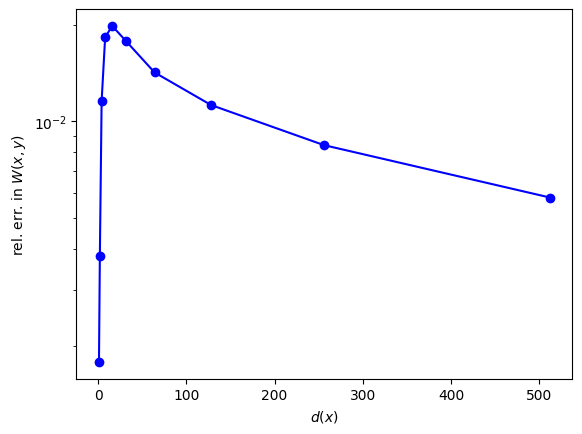

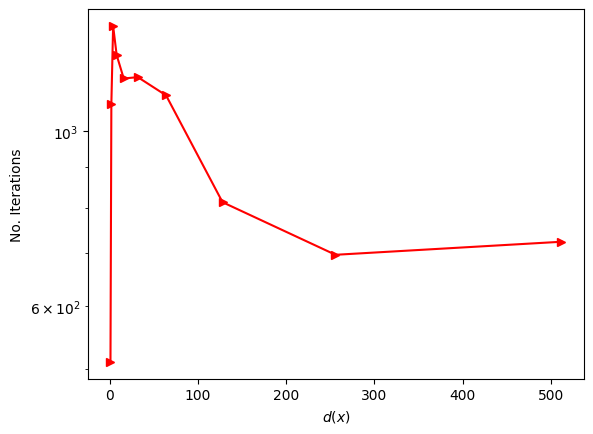

In [ ]:
fig, ax = plt.subplots();
ax.plot(nds, errors_xy, marker="o", color="blue")
ax.set_ylabel(r"rel. err. in $W(x,y)$")
ax.set_xlabel(r"$d(x)$")
#ax.set_xscale("log")
ax.set_yscale("log")

fig, ax = plt.subplots();
ax.plot(nds, iter_coll_xy, marker=">", color="red")
ax.set_ylabel(r"No. Iterations")
ax.set_xlabel(r"$d(x)$")
#ax.set_xscale("log")
ax.set_yscale("log")



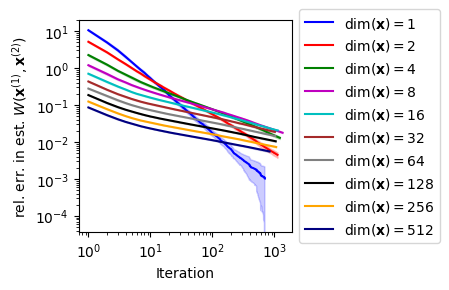

In [ ]:
fig, ax = plt.subplots();
cls = ["blue", "red", "green", "m", "c", "brown", "gray", "k", "orange", "navy"] #["blue", "red", "green", "m", "c", "brown", "yellow", "k", "orange", "navy"]
for k in range(len(nds)):
    nmin = 10000000
    for jj in range(len(hist_coll_w[k])):
      if len(hist_coll_w[k][jj]) < nmin:
        nmin = len(hist_coll_w[k][jj])
    hist_coll_w_k = np.zeros( (len(hist_coll_w[k]), nmin) )
    for jj in range(len(hist_coll_w[k])):
      for ii in range(nmin):
        hist_coll_w_k[jj,ii] = hist_coll_w[k][jj][ii]
    xx = [i+1 for i in range(nmin)]
    mean_err = np.mean(hist_coll_w_k, axis=0)
    std_err = np.var(hist_coll_w_k,axis=0)**0.5
    ax.plot(xx, mean_err, color=cls[k], markevery=100, label=r"$\dim(\mathbf{x})="+str(nds[k])+"$")
    plt.fill_between(xx, mean_err-std_err, mean_err+std_err, color=cls[k], alpha=0.2)
    #for av in range(navg):
    #    ax.plot(hist_coll_w[k][av], color=cls[k], marker=markers[av], markevery=100, label=r"$d(x)="+str(nds[k])+"\ rep.\ "+str(av+1)+"$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"rel. err. in est. $W(\mathbf{x}^{(1)},\mathbf{x}^{(2)})$")
ax.set_xlabel("Iteration")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

fig.set_size_inches(size*cm, size*cm)
plt.savefig('drive/MyDrive/OT/nd_bi-modal-multivar_evol_rel_error_Dim.pdf',format='pdf', bbox_inches="tight", dpi=300);

## Swiss roll and ring

In [ ]:
from sklearn.datasets import make_swiss_roll

def generate_half_moon_samples(num_samples, radius=2, distance=0.5, noise=0.01, center=[0,0]):
    # Generate half-moon samples
    num_samples *= 2
    angles = np.random.rand(int(num_samples/2)) * np.pi * 2
    radius_noise = np.random.randn(int(num_samples/2)) * noise
    x1 = center[0] + radius + radius_noise - distance/2 + radius * np.cos(angles)
    y1 = center[1] + radius_noise + radius * np.sin(angles)
    half_moon_samples = np.column_stack((x1,y1))
    return half_moon_samples

def sample_moon_swissroll(Np, nd, noise = 0.2):
  x = np.zeros((Np,nd))
  y = np.zeros((Np,nd))

  # sample x
  for d in range(int(nd/2)):
    x_, _= make_swiss_roll(Np, noise=noise)
    x[:,2*d] = 0.1*x_[:,0] + np.sin(4*np.pi*d/nd)*2
    x[:,2*d+1] = 0.1*x_[:,2] + np.cos(4*np.pi*d/nd)*2

  # sample z
  for d in range(int(nd/2)):
    c = [np.cos(4*np.pi*d/nd)*5, np.sin(4*np.pi*d/nd)*5]
    y_= generate_half_moon_samples(Np, radius=2, center=c, noise=noise)
    y[:,2*d] = 0.5*y_[:,0]
    y[:,2*d+1] = 0.5*y_[:,1]

  return x, y

63.66737289908926


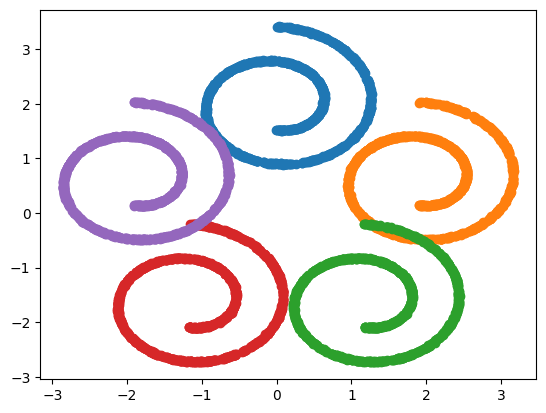

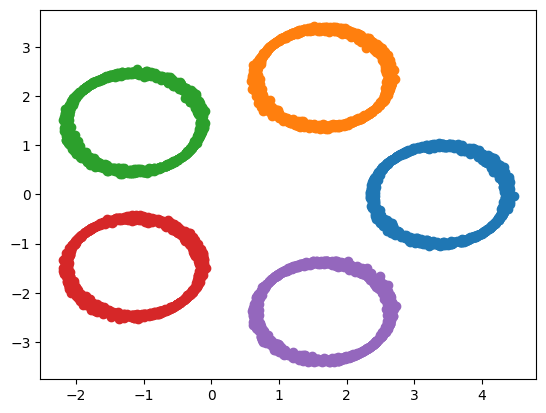

In [ ]:
# Example: sample for 10 dimensional, each two are a certain shape
nd = 10
Np = 1000
x, y = sample_moon_swissroll(Np=Np, nd=nd, noise = 0.05)

d = 2
X = np.zeros( (nd, Np, d) )
X[:,:,0] = x.T
X[:,:,1] = y.T

plt.figure()
[plt.scatter(X[2*d,:,0], X[2*d+1,:,0]) for d in range(int(nd/2))]

plt.figure()
[plt.scatter(X[2*d,:,1], X[2*d+1,:,1]) for d in range(int(nd/2))]

In [ ]:
import time
Nps = [100, 200, 400, 800, 1600, 3200, 6400]

errors_xy = []

ex_time_emd  = []
ex_time_coll = []
iter_coll_xy = []
hist_coll_w = [[] for i in range(len(Nps))]

k=0
navg = 1
nd = 4
for Np in Nps:
  print("Np: ", Np)
  k = k + 1

  emd_t = 0
  coll_t = 0
  errors_xy_ = 0
  errors_yz_ = 0
  errors_xz_ = 0
  nt_xy_ = 0
  nt_yz_ = 0
  for av in range(navg):
      x00, y00 = sample_moon_swissroll(Np=Np, nd=nd)

      ## compute EMD
      x_emd = x00.copy(); y_emd = y00.copy();

      start_time = time.time()
      x_emd, y_emd = find_optimal_map_nd(x_emd, y_emd)
      emd_t += time.time() - start_time
      print("EMD Done")

      ## compute collision based
      x_coll = x00.copy(); y_coll = y00.copy();

      start_time = time.time()
      x_coll, y_coll, dists_coll_xy, nt_xy = find_OT_collision_nd(x_coll, y_coll, tol=1e-6, MinIter=100, MaxIter=10000)
      coll_t += time.time() - start_time
      print("coll Done")

      w_emd_xy = np.mean(np.mean(np.sum((x_emd-y_emd)**2, axis=1)))
      w_coll_xy = np.mean(np.mean(np.sum((x_coll-y_coll)**2, axis=1)))
      errors_xy_ += abs(w_emd_xy-w_coll_xy) / w_emd_xy
      hist_coll_w[k-1].append(np.array( (dists_coll_xy)-w_emd_xy)/ w_emd_xy )

      nt_xy_ += nt_xy

  iter_coll_xy.append(nt_xy_/navg)

  ex_time_emd.append(emd_t/navg)
  ex_time_coll.append(coll_t/navg)

  errors_xy.append( errors_xy_/navg )

Np:  100
EMD Done
coll Done
Np:  200
EMD Done
coll Done
Np:  400
EMD Done
coll Done
Np:  800
EMD Done
coll Done
Np:  1600
EMD Done
coll Done
Np:  3200
EMD Done
coll Done
Np:  6400
EMD Done
coll Done


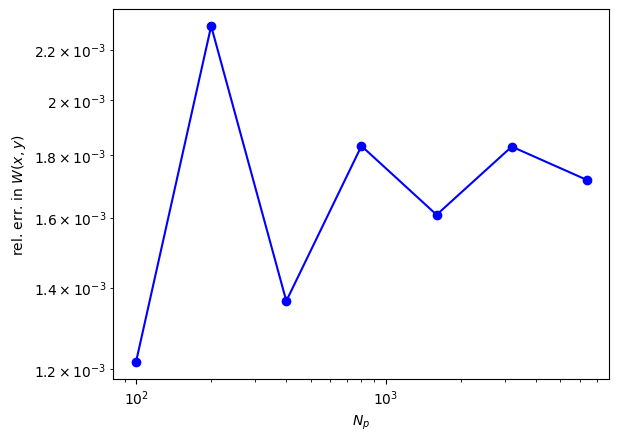

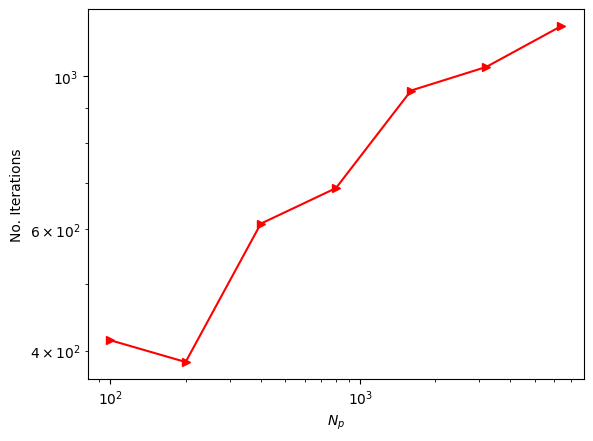

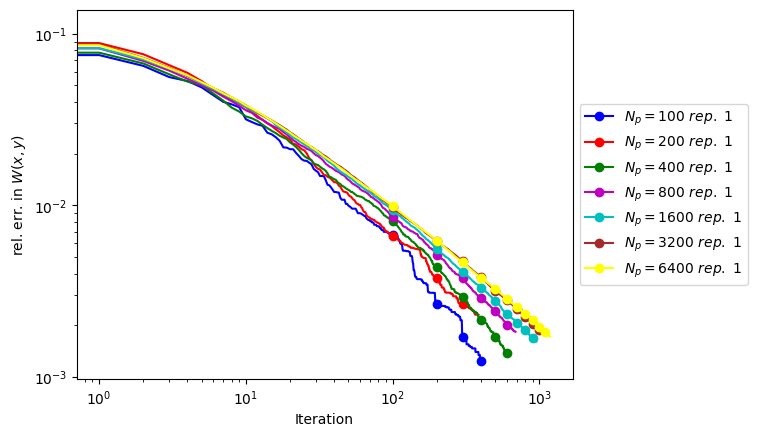

In [ ]:
fig, ax = plt.subplots();
ax.plot(Nps, errors_xy, marker="o", color="blue")
ax.set_ylabel(r"rel. err. in $W(x,y)$")
ax.set_xlabel(r"$N_p$")
ax.set_xscale("log")
ax.set_yscale("log")

fig, ax = plt.subplots();
ax.plot(Nps, iter_coll_xy, marker=">", color="red")
ax.set_ylabel(r"No. Iterations")
ax.set_xlabel(r"$N_p$")
ax.set_xscale("log")
ax.set_yscale("log")



fig, ax = plt.subplots();
cls = ["blue", "red", "green", "m", "c", "brown", "yellow"]
for k in range(len(Nps)):
    for av in range(navg):
        ax.plot(hist_coll_w[k][av], color=cls[k], marker=markers[av], markevery=100, label=r"$N_p="+str(Nps[k])+"\ rep.\ "+str(av+1)+"$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"rel. err. in $W(x,y)$")
ax.set_xlabel("Iteration")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

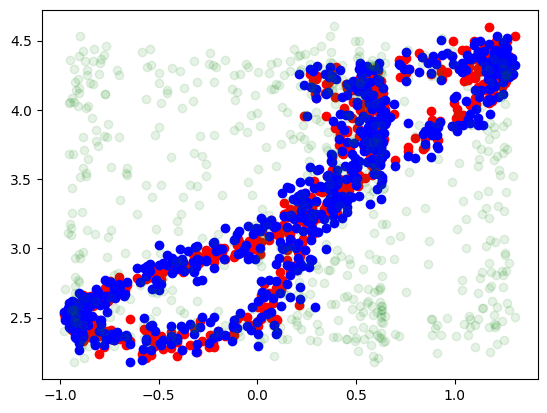

In [ ]:
plt.figure()
plt.scatter(x_emd[::10,0], y_emd[::10,0], color='red', label="EMD")
plt.scatter(x_coll[::10,0], y_coll[::10,0], color='blue', label="coll")
plt.scatter(x00[::10,0], y00[::10,0], color='green', label="Initial samples", alpha=0.1)

In [ ]:
import time
nds = [2**i for i in range(1,10)]

errors_xy = []

ex_time_emd  = []
ex_time_coll = []
iter_coll_xy = []
hist_coll_w = [[] for i in range(len(nds))]

k=0
navg = 1
Np = 1000
for nd in nds:
  print("d: ", nd)
  k = k + 1

  emd_t = 0
  coll_t = 0
  errors_xy_ = 0
  errors_yz_ = 0
  errors_xz_ = 0
  nt_xy_ = 0
  nt_yz_ = 0
  for av in range(navg):
      x00, y00 = sample_moon_swissroll(Np=Np, nd=nd)

      ## compute EMD
      x_emd = x00.copy(); y_emd = y00.copy();

      start_time = time.time()
      x_emd, y_emd = find_optimal_map_nd(x_emd, y_emd)
      emd_t += time.time() - start_time
      print("EMD Done")

      ## compute collision based
      x_coll = x00.copy(); y_coll = y00.copy();

      start_time = time.time()
      x_coll, y_coll, dists_coll_xy, nt_xy = find_OT_collision_nd(x_coll, y_coll, tol=1e-10, MinIter=1000, MaxIter=10000)
      coll_t += time.time() - start_time
      print("coll Done")

      w_emd_xy = np.mean(np.mean(np.sum((x_emd-y_emd)**2, axis=1)))
      w_coll_xy = np.mean(np.mean(np.sum((x_coll-y_coll)**2, axis=1)))
      errors_xy_ += abs(w_emd_xy-w_coll_xy) / w_emd_xy
      hist_coll_w[k-1].append((np.array(dists_coll_xy)-w_emd_xy)/w_emd_xy)

      nt_xy_ += nt_xy

  iter_coll_xy.append(nt_xy_/navg)

  ex_time_emd.append(emd_t/navg)
  ex_time_coll.append(coll_t/navg)

  errors_xy.append( errors_xy_/navg )

d:  2
EMD Done
coll Done
d:  4
EMD Done
coll Done
d:  8
EMD Done
coll Done
d:  16
EMD Done
coll Done
d:  32
EMD Done
coll Done
d:  64
EMD Done
coll Done
d:  128
EMD Done
coll Done
d:  256
EMD Done
coll Done
d:  512
EMD Done
coll Done


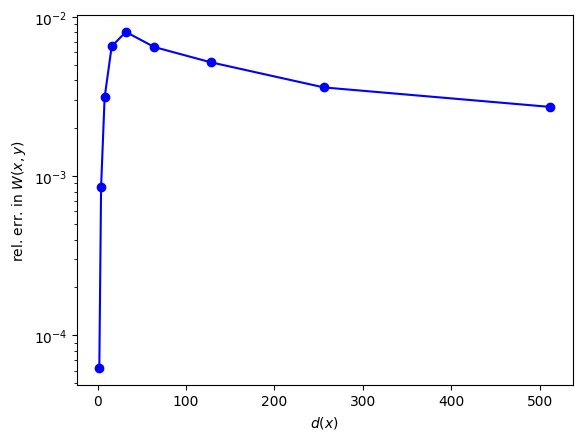

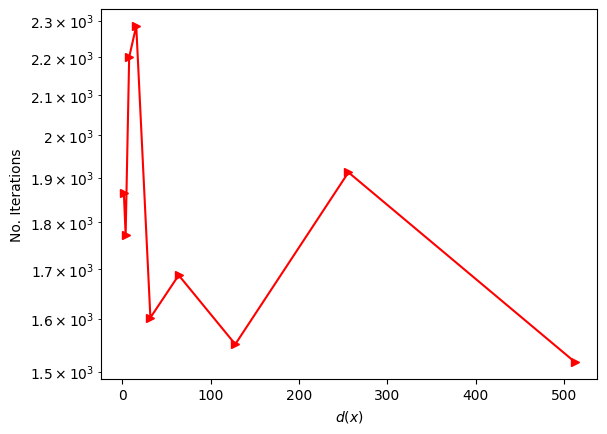

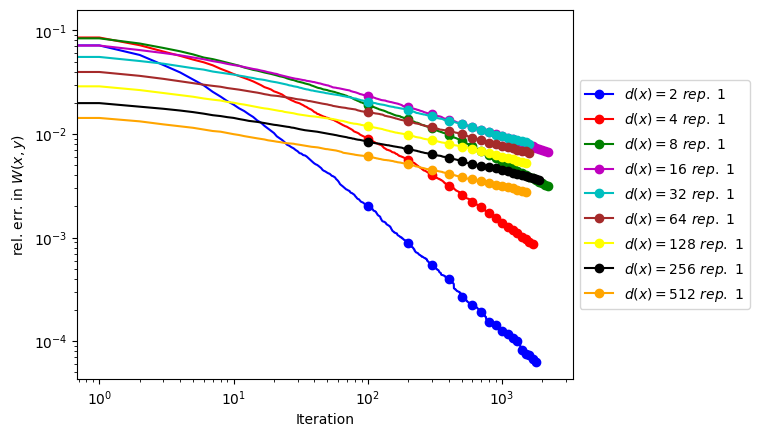

In [ ]:
fig, ax = plt.subplots();
ax.plot(nds, errors_xy, marker="o", color="blue")
ax.set_ylabel(r"rel. err. in $W(x,y)$")
ax.set_xlabel(r"$d(x)$")
#ax.set_xscale("log")
ax.set_yscale("log")

fig, ax = plt.subplots();
ax.plot(nds, iter_coll_xy, marker=">", color="red")
ax.set_ylabel(r"No. Iterations")
ax.set_xlabel(r"$d(x)$")
#ax.set_xscale("log")
ax.set_yscale("log")

fig, ax = plt.subplots();
cls = ["blue", "red", "green", "m", "c", "brown", "yellow", "k", "orange", "navy"]
for k in range(len(nds)):
    for av in range(navg):
        ax.plot(hist_coll_w[k][av], color=cls[k], marker=markers[av], markevery=100, label=r"$d(x)="+str(nds[k])+"\ rep.\ "+str(av+1)+"$")
ax.set_xscale("log")
ax.set_yscale("log")
ax.set_ylabel(r"rel. err. in $W(x,y)$")
ax.set_xlabel("Iteration")
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))

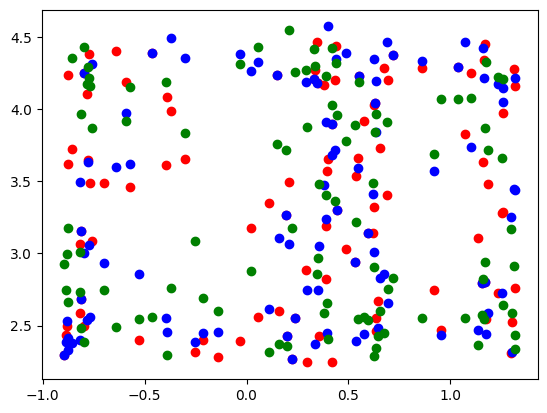

In [ ]:
plt.figure()
#ax = plt.axes(projection='3d', elev=20, azim=10)
plt.scatter(x_emd[::10,2], y_emd[::10,2], color='red', label="EMD")
plt.scatter(x_coll[::10,2], y_coll[::10,2], color='blue', label="coll")
plt.scatter(x00[::10,2], y00[::10,2], color='green', label="Initial samples")

In [ ]:
np.sum( np.mean( (x_coll-y_coll)**2,axis=0) )

22.624757183423295

In [ ]:
np.sum( np.mean( (x_emd-y_emd)**2,axis=0) )

22.6069931094284

In [ ]:
np.sum( np.mean( (x00-y00)**2,axis=0) )

25.118310159590592

# Multi Marginal Test Case

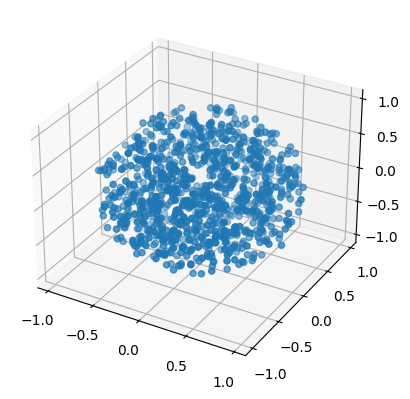

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def sample_uniformly_in_sphere(num_points, dim):
    # Generate random points from a standard normal distribution
    points = np.random.randn(num_points, dim)

    # Normalize the points to lie on the surface of the unit sphere
    points /= np.linalg.norm(points, axis=1)[:, np.newaxis]

    # Scale points by a factor drawn from the fourth root of a uniform distribution
    # This ensures the points are uniformly distributed inside the sphere
    radii = np.random.uniform(0, 1, num_points) ** (1 / dim)
    points *= radii[:, np.newaxis]

    return points

# Sampling 1000 points inside a 4-dimensional unit sphere
num_points = 1000
dim = 3
points_in_sphere = sample_uniformly_in_sphere(num_points, dim)

fig = plt.figure()
ax = plt.axes(projection='3d')
# points_in_sphere now contains 1000 points inside the 4D sphere
ax.scatter(points_in_sphere[:,0], points_in_sphere[:,1], points_in_sphere[:,2])

In [ ]:
from numpy.random import default_rng

rng = default_rng()

def cost(x, s, t):
  return abs( np.sum(s[0,:,:]*x)-t[0] ) + abs( np.sum(s[1,:,:]*x)-t[1]) - abs( np.sum(s[2,:]*x)-t[2]) - abs( np.sum(s[3,:]*x)-t[3])

def find_OT_collision_nd_nmarginal(x, s, t = [0,0,0,0],  MinIter=20, MaxIter=100000, tol = 1e-3, avg_window=20):
    # x with size (N, dim)
    # s with size (4, N, dim)
    dists_coll = [cost(x, s, t)]
    Np = x.shape[0]
    tries = Np
    sum_ = 1000000
    r_list = len(x)
    for nt in range(1, MaxIter+1):
        #tries = Np
        iss = rng.choice(r_list, size=tries, replace=False)
        i1s = iss[:int(tries/2)]
        i2s = iss[int(tries/2):]

        for i in range(int(Np/2)):
          sold = abs(np.sum(s[0,iss,:]*x[iss,:]) - t[0])
          sold += abs(np.sum(s[1,iss,:]*x[iss,:]) - t[1])
          sold += -abs(np.sum(s[2,iss,:]*x[iss,:]) - t[2])
          sold += -abs(np.sum(s[3,iss,:]*x[iss,:]) - t[3])

          snew  = abs( np.sum(s[0,iss,:]*x[iss,:]) - t[0] - np.sum(s[0,i1s[i],:]*x[i1s[i],:]) - np.sum(s[0,i2s[i],:]*x[i2s[i],:]) + np.sum(s[0,i1s[i],:]*x[i2s[i],:]) + np.sum(s[0,i2s[i],:]*x[i1s[i],:]) )
          snew += abs( np.sum(s[1,iss,:]*x[iss,:]) - t[1] - np.sum(s[1,i1s[i],:]*x[i1s[i],:]) - np.sum(s[1,i2s[i],:]*x[i2s[i],:]) + np.sum(s[1,i1s[i],:]*x[i2s[i],:]) + np.sum(s[1,i2s[i],:]*x[i1s[i],:]) )
          snew += -abs( np.sum(s[2,iss,:]*x[iss,:]) - t[2] - np.sum(s[2,i1s[i],:]*x[i1s[i],:]) - np.sum(s[2,i2s[i],:]*x[i2s[i],:]) + np.sum(s[2,i1s[i],:]*x[i2s[i],:]) + np.sum(s[2,i2s[i],:]*x[i1s[i],:]) )
          snew += -abs( np.sum(s[3,iss,:]*x[iss,:]) - t[3] - np.sum(s[3,i1s[i],:]*x[i1s[i],:]) - np.sum(s[3,i2s[i],:]*x[i2s[i],:]) + np.sum(s[3,i1s[i],:]*x[i2s[i],:]) + np.sum(s[3,i2s[i],:]*x[i1s[i],:]) )
          if snew < sold:
            temp = x[i1s[i]].copy()
            x[i1s[i]] = x[i2s[i]].copy()
            x[i2s[i]] = temp.copy()

        dists_coll.append( cost(x, s, t) )

        if nt>avg_window and nt > MinIter:
          sum_0 = np.sum(np.array(dists_coll)[-avg_window:])
          if abs(sum_ - sum_0)/sum_0 < tol:
            break
          sum_ = sum_0
    return x, s, dists_coll, nt

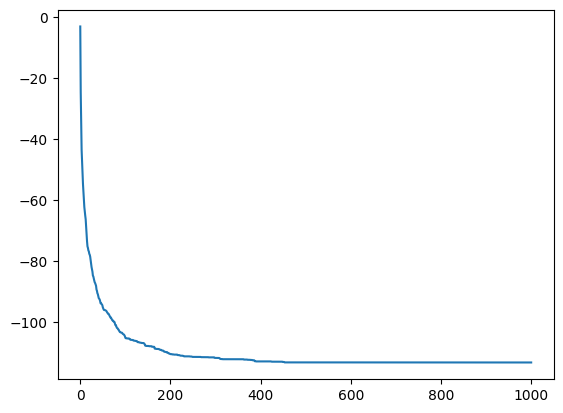

In [ ]:
N = 50
nd = 50
nens = 10

dists_coll_ens = []
for ens in range(nens):
  x = np.random.normal(0,1,(N,nd))
  s = np.array([sample_uniformly_in_sphere(N, nd) for i in range(4)])
  x, s, dists_coll, nt = find_OT_collision_nd_nmarginal(x, s, t = [0,0,0,0],  MinIter=100, MaxIter=100, tol = 1e-9, avg_window=40)
  dists_coll_ens.append(dists_coll)
dists_coll_ens = np.array(dists_coll_ens)

plt.plot(np.mean(dists_coll_ens,axis=0))


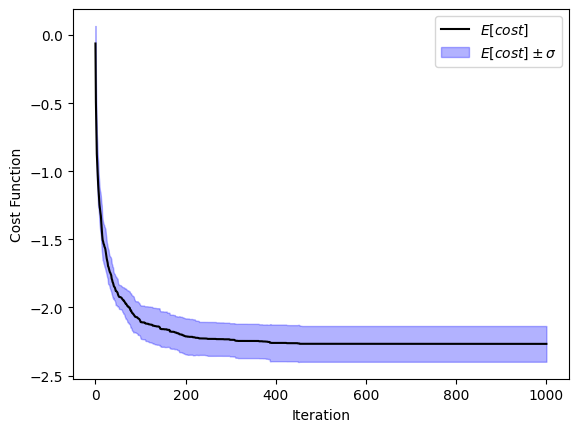

In [ ]:
mean = np.mean(dists_coll_ens,axis=0)/N
std = np.std(dists_coll_ens/N,axis=0)

fig, ax = plt.subplots();

ax.set_ylabel(r"Cost Function")
ax.set_xlabel(r"Iteration")

x = [i for i in range(len(mean))]
ax.plot(x, mean, color="black", label=r"$E[cost]$")
ax.fill_between(x, mean + std, mean - std, color='blue', alpha=0.3, label=r"$E[cost]\pm \sigma$")
plt.legend()
plt.savefig('cost.png')

<Figure size 640x480 with 0 Axes>

In [ ]:
tries = 10
r_list = len(x)
iss = rng.choice(r_list, size=tries, replace=False)
i1s = iss[:int(tries/2)]
i2s = iss[int(tries/2):]

abs( np.sum(s[0,i1s,:]*x[i1s,:], axis=1))

array([0.84270553, 0.005258  , 0.53463269, 0.22066594, 0.27969945])

In [ ]:
i1s

array([4, 8, 9, 1, 0])

In [ ]:
i2s

array([5, 7, 6, 2, 3])

# Multi-Marginal (corrected code)

In [ ]:
from numpy.random import default_rng

rng = default_rng()


def find_OT_collision_nd_nmargins(x, Total_Cost, Change_Cost, MinIter=20, MaxIter=100000, tol = 1e-3, avg_window=20):
    # x with size (Nmargins, N, dim)
    Nm = x.shape[0] # number of margins
    Np = x.shape[1] # number of samples per margin
    tries = Np
    sum_ = 1000000
    ids = np.array([[i for i in range(Np)] for j in range(Nm)]) # Nmargines, Np

    dists_coll = [Total_Cost(x, ids)]

    for nt in range(1, MaxIter+1):
        for k in range(Nm):
            iss = rng.choice(Np, size=tries, replace=False)
            i1s = iss[:int(tries/2)]
            i2s = iss[int(tries/2):]

            s0 = Change_Cost(x, ids, i1s, i2s, k, before=True)
            s1 = Change_Cost(x, ids, i1s, i2s, k, before=False)

            # Determine which swaps to accept
            mask = s1 < s0

            # Perform the swaps for accepted cases
            accepted_i1s = i1s[mask]
            accepted_i2s = i2s[mask]

            #ids[k,accepted_i1s], ids[k,accepted_i2s] = ids[k,accepted_i2s].copy(), ids[k,accepted_i1s].copy()
            x[k,accepted_i1s,:], x[k,accepted_i2s,:] = x[k,accepted_i2s,:].copy(), x[k,accepted_i1s,:].copy()

        cost = Total_Cost(x, ids)
        dists_coll.append( cost )

        if nt>avg_window and nt > MinIter:
            sum_0 = np.sum(np.array(dists_coll)[-avg_window:])
            if abs(sum_ - sum_0)/sum_0 < tol:
              break
            sum_ = sum_0

    return x, ids, dists_coll, nt

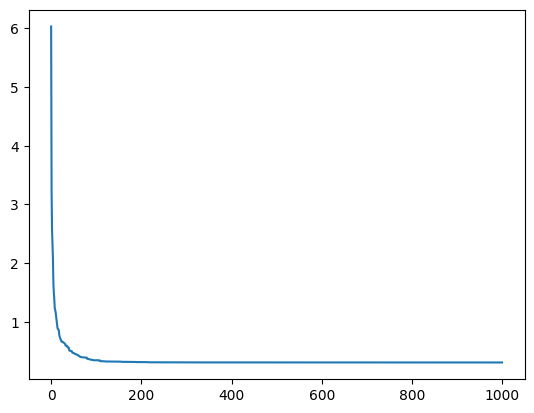

In [ ]:
def total_cost(x_m, ids_m):
  Nm_m = x_m.shape[0]
  Np_m = x_m.shape[1]
  y = 0
  for i in range(Nm_m):
    for j in range(i+1, Nm_m):
        #y += np.sum( np.sum( (x_m[i, ids_m[i,:]]-x_m[j, ids_m[j,:],:])**2 , axis=1) )
        y += np.sum( np.sum( (x_m[i, :, :]-x_m[j, :, :])**2 , axis=1) )
  return y/Np_m

def change_cost(x_m, ids_m, i1s_m, i2s_m, k_m, before=True):
  Nm_m = x_m.shape[0]
  s_m = np.ones(len(i1s_m))
  for j_m in range(Nm_m):
    if j_m != k_m:
        #s_m += np.sum( np.sum( (x_m[j_m,ids_m[j_m,:],:]-x_m[k_m,ids_m[k_m,:],:])**2, axis=1) )
        s_m += np.sum( np.sum( (x_m[j_m,:,:]-x_m[k_m,:,:])**2, axis=1) )

        if before is False:
          #s_m -= np.sum( (x_m[j_m,ids_m[j_m,i1s_m],:]-x_m[k_m,ids_m[k_m,i1s_m],:])**2, axis=1)
          #s_m -= np.sum( (x_m[j_m,ids_m[j_m,i2s_m],:]-x_m[k_m,ids_m[k_m,i2s_m],:])**2, axis=1)
          #s_m += np.sum( (x_m[j_m,ids_m[j_m,i1s_m],:]-x_m[k_m,ids_m[k_m,i2s_m],:])**2, axis=1)
          #s_m += np.sum( (x_m[j_m,ids_m[j_m,i2s_m],:]-x_m[k_m,ids_m[k_m,i1s_m],:])**2, axis=1)

          s_m -= np.sum( (x_m[j_m,i1s_m,:]-x_m[k_m,i1s_m,:])**2, axis=1)
          s_m -= np.sum( (x_m[j_m,i2s_m,:]-x_m[k_m,i2s_m,:])**2, axis=1)
          s_m += np.sum( (x_m[j_m,i1s_m,:]-x_m[k_m,i2s_m,:])**2, axis=1)
          s_m += np.sum( (x_m[j_m,i2s_m,:]-x_m[k_m,i1s_m,:])**2, axis=1)

  return s_m

Nm = 2
Nd = 2
Np = 100
X = np.zeros((Nm,Np,Nd))
for nm in range(Nm):
  X[nm,:,:] = np.random.normal(0.1*Nm, 1+0.1*Nm, (Np, Nd))

X, ids, dists, nt = find_OT_collision_nd_nmargins(X, Total_Cost=total_cost,  Change_Cost=change_cost, MinIter=1000, MaxIter=1000, tol = 1e-6, avg_window=20)

plt.figure()
plt.plot(dists)

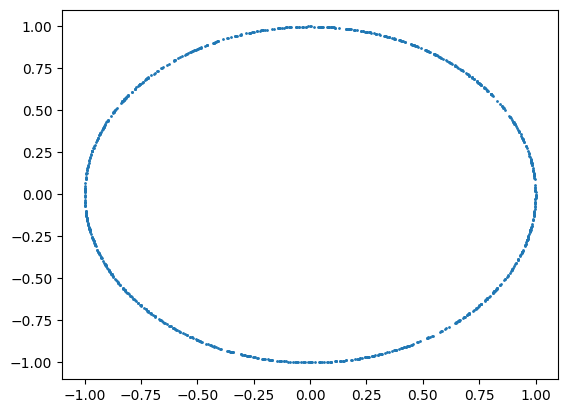

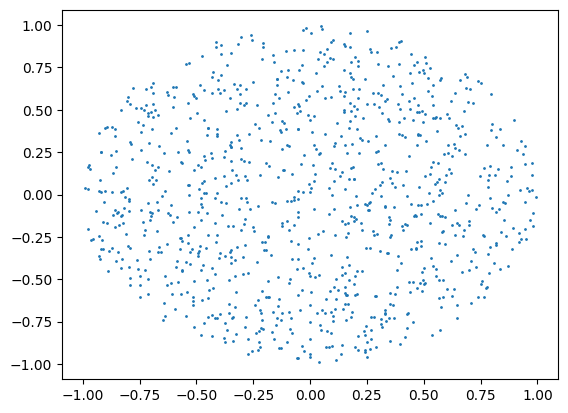

In [ ]:
num_samples = 1000
dim = 2

points = np.random.normal(size=(num_samples, dim))

#    # Step 2: Normalize the points to lie on the unit sphere
unit_vectors = points / np.linalg.norm(points, axis=1)[:, np.newaxis]

fig = plt.figure()
plt.scatter(unit_vectors[:,0], unit_vectors[:,1], s=1)

#    # Step 3: Scale by a random radius uniformly distributed within the sphere
samples = unit_vectors  * ( np.random.rand(num_samples) ** (1.0 / dim) ) [:, np.newaxis]

fig = plt.figure()
plt.scatter(samples[:,0], samples[:,1], s=1)

(500, 3)


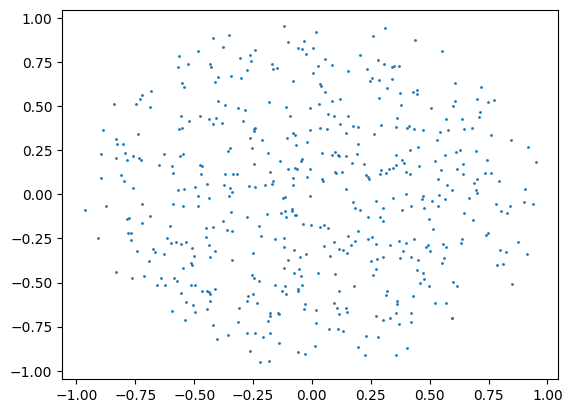

In [2]:
import numpy as np

def sample_n_dimensional_sphere(num_samples=1, dim=1):
    # Step 1: Sample points from a normal distribution
    points = np.random.normal(size=(num_samples, dim))

    # Step 2: Normalize the points to lie on the unit sphere
    unit_vectors = points / np.linalg.norm(points, axis=1)[:, np.newaxis]

    # Step 3: Scale by a random radius uniformly distributed within the sphere
    random_radii = np.random.rand(num_samples) ** (1.0 / dim)
    samples = unit_vectors * random_radii[:, np.newaxis]

    return samples

# Example usage:
dim = 3  # Dimension of the sphere
num_samples = 500  # Number of points to sample
samples = sample_n_dimensional_sphere(num_samples, dim)

# 'samples' is an array of shape (num_samples, n) with each row representing a point in the N-dimensional sphere
print(samples.shape)

fig = plt.figure()
#ax = plt.axes(projection='3d')
plt.scatter(samples[:,0], samples[:,1], s=1) #, samples[:,2])


In [3]:
import numpy as np
from matplotlib import pyplot as plt
# sk, [0-4, Nmarginal, Np, nd]

def total_cost(x_m, ids_m):
  # x_m [Nmarginal, Np, nd]
  Nm_m = x_m.shape[0]
  Np_m = x_m.shape[1]
  y = 0
  for i_m in range(4):
      dummy = 0
      for j_m in range(Nm_m):
          dummy += np.sum(sk[i_m,j_m,:,:]*x_m[j_m,:,:])
      dummy += -tk[i_m]
      if i_m<2:
           y += abs(dummy)
      else:
           y += -abs(dummy)
  return y

def change_cost(x_m, ids_m, i1s_m, i2s_m, k_m, id_m=None, before=True, ISvectorized=True):
  Nm_m = x_m.shape[0]
  s_m = np.ones(len(i1s_m))
  s_test = 0
  solds = np.zeros((4, Nm_m))
  iss = np.concatenate([i1s_m, i2s_m])
  for j_m in range(Nm_m):
    for i_m in range(4):
        solds[i_m, j_m] = np.sum( sk[i_m,j_m, :,:] * x_m[j_m,:,:] )

  if before is True:
        s_m = 0.
        for i_m in range(4):
            dummy = 0. #np.zeros_like(s_m)
            for j_m in range(Nm_m):
              dummy += solds[i_m,j_m]
            dummy += - tk[i_m]
            if i_m<2:
              s_m += abs(dummy)
            else:
              s_m += -abs(dummy)
        s_m = s_m * np.ones(len(i1s_m))
  else:
    if ISvectorized==True:
        for i_m in range(4):
          dummy = np.zeros_like(s_m)
          for j_m in range(Nm_m):
              dummy += solds[i_m, j_m]
              if j_m == k_m:
                  dummy += - np.sum( sk[i_m,j_m,i1s_m,:]*x_m[k_m,i1s_m,:], axis=1 )
                  dummy += - np.sum( sk[i_m,j_m,i2s_m,:]*x_m[k_m,i2s_m,:], axis=1 )
                  dummy +=   np.sum( sk[i_m,j_m,i1s_m,:]*x_m[k_m,i2s_m,:], axis=1 )
                  dummy +=   np.sum( sk[i_m,j_m,i2s_m,:]*x_m[k_m,i1s_m,:], axis=1 )
          dummy += - tk[i_m]
          if i_m<2:
            s_m += abs(dummy)
          else:
            s_m += -abs(dummy)
    else:
        s_m = 0.
        for i_m in range(4):
          dummy = 0.0
          for j_m in range(Nm_m):
              dummy += solds[i_m, j_m]
              if j_m == k_m:
                  dummy += - np.sum( sk[i_m,j_m,i1s_m[id_m],:]*x_m[k_m,i1s_m[id_m],:], axis=1 )
                  dummy += - np.sum( sk[i_m,j_m,i2s_m[id_m],:]*x_m[k_m,i2s_m[id_m],:], axis=1 )
                  dummy +=   np.sum( sk[i_m,j_m,i1s_m[id_m],:]*x_m[k_m,i2s_m[id_m],:], axis=1 )
                  dummy +=   np.sum( sk[i_m,j_m,i2s_m[id_m],:]*x_m[k_m,i1s_m[id_m],:], axis=1 )
          dummy += - tk[i_m]
          if i_m<2:
            s_m += abs(dummy)
          else:
            s_m += -abs(dummy)
  return s_m

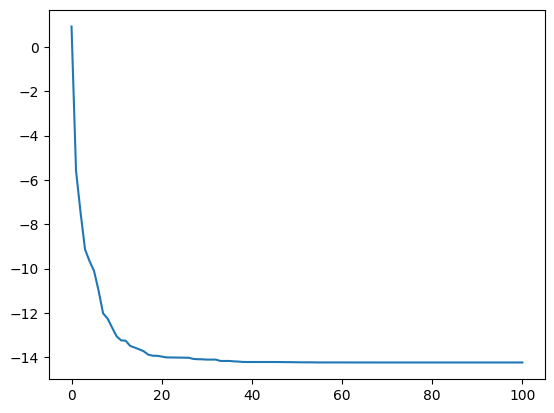

In [ ]:
Nm = 50
Nd = 1
Np = 10

#X = np.random.normal(0,1,(Nm, Np, Nd))
#sk = np.random.normal(0,1,(4, Nm, Np, Nd))
#tk = np.random.normal(0,1,(4))

X = sampleX_nd(Nm, Np)[:,:,None]

tk = np.random.normal(0, 1, (4)) #np.random.uniform(-1,1,(4))

sk = np.zeros((4,Nm,Np,Nd))

for i in range(4):
  for nd in range(Nd):
    sk[i, :, :, nd] = sample_n_dimensional_sphere(Np, Nm).T

X, ids, dists, nt = find_OT_collision_nd_nmargins_new(X, Total_Cost=total_cost,  Change_Cost=change_cost, MinIter=100, MaxIter=100, tol = 1e-6, avg_window=20, ISvectorized=False)

plt.figure()
plt.plot(np.array(dists)/Np)

In [21]:
import numpy as np

def sampleX(mus, sigs):
    #mus = np.random.normal(0, 1, (3)) * 3
    #sigs = 1./np.random.gamma(3., 1., 3)
    r = np.random.uniform(0,1)
    if r < 0.33:
        return np.random.normal(mus[0],sigs[0])
    elif r > 0.33 and r < 0.66:
        return np.random.normal(mus[1],sigs[1])
    else:
        return np.random.normal(mus[2],sigs[2])

def sampleX_nd(Nm, Np):
    x = np.zeros((Nm, Np))
    for i in range(Nm):
        mus = np.random.normal(0, 1, (3)) * 3
        sigs = 1./np.random.gamma(3., 1., 3)
        for j in range(Np):
            x[i,j] = sampleX(mus, sigs)
            if abs( x[i,j] ) > 10:
                res = False
                while res is False:
                    dummy = sampleX(mus, sigs)
                    if abs( dummy ) < 10:
                        x[i,j] = dummy
                        res = True
    return x

Np = 1000
Nm = 50
Nd = 1
nens = 50

dists_coll_ens = []
for ens in range(nens):

  X = sampleX_nd(Nm, Np)[:,:,None]

  tk = np.random.normal(0, 1, (4)) #* 2 #np.random.uniform(-1,1,(4))

  sk = np.zeros((4,Nm,Np,Nd))

  for i in range(4):
    for nd in range(Nd):
      sk[i, :, :, nd] = sample_n_dimensional_sphere(Np, Nm).T

  X, ids, dists, nt = find_OT_collision_nd_nmargins_new(X, Total_Cost=total_cost,  Change_Cost=change_cost, MinIter=50, MaxIter=50, tol = 1e-6, avg_window=20, ISvectorized=False)

  if ens % 1 == 0:
    print("ens:",ens)
    print("dists[0]:", dists[0]/Np, " dists[-1]:", dists[-1]/Np)
  dists_coll_ens.append(dists)


ens: 0
dists[0]: -0.05858545380496744  dists[-1]: -18.12259146843933
ens: 1
dists[0]: 0.16536902865621042  dists[-1]: -17.682398763579968
ens: 2
dists[0]: -0.09347261692051738  dists[-1]: -17.33935315994765


KeyboardInterrupt: 

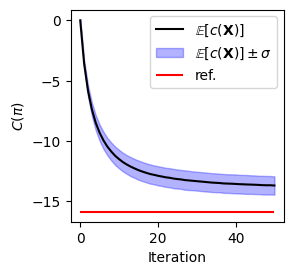

In [20]:
mean = np.mean(dists_coll_ens,axis=0)/Np
std = np.std(np.array(dists_coll_ens)/Np,axis=0)

fig, ax = plt.subplots();

ax.set_ylabel(r"$C(\pi)$")
ax.set_xlabel(r"Iteration")

x = [i for i in range(len(mean))]
ax.plot(x, mean, color="black", label=r"$\mathbb{E}[c(\mathbf{X})]$")
ax.fill_between(x, mean + std, mean - std, color='blue', alpha=0.3, label=r"$\mathbb{E}[c(\mathbf{X})]\pm \sigma$")
ax.hlines(xmin=np.min(x), xmax=np.max(x), y=-15.9, color="red", label="ref.")
plt.legend()
#plt.savefig('cost.png')

fig.set_size_inches(size*cm, size*cm)
#plt.savefig('drive/MyDrive/OT/nmarginal.pdf',format='pdf', bbox_inches="tight", dpi=300);

In [ ]:
a = [-5276.1872709057125,
-8279.58559762223,
-10250.926142888864,
-11581.680515132235,
-12601.067502445501,
-13444.811179207856,
-14106.182654453507,
-14638.820918792284,
-15022.371129399202,
-15383.799620109876,
-15696.218818075398,
-15987.344690331101,
-16255.661768509064,
-16425.45882550386]

In [ ]:
-2500/50

-50.0